In [2]:
# load necessary libraries

# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2

import os, time
# select GPU for training
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# import tensorflow.experimental.numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import random
import scipy.io as scio
import h5py 
import math

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)
    
import sys
sys.path.append("../../")
import lib
from lib.proc import *
from lib.simu import *
from lib.commons import *
from lib.net import *




In [3]:
# hyper parameters definition
LENGTH = 130
CV_SP = 0
reg = 1e-2
prefix = "T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len%s-CV%s-RoQ-comparison-checkdata-relusigmoid-largekep"%(str(LENGTH),str(CV_SP))
ISTRAIN = False
sample_pattern = 'RES01'
# parameters to set
DCE_DIM = 360
INIT_DIM = 4

OUT_DIM = LENGTH
IN_DIM = OUT_DIM
PK_DIM = 2

BATCH_SIZE = 1 # 
LR_RATE = 1e-3

LAYER_NUM = 4
FEATURE_NUM = 64

hct=0.4
del_t = 2 

print(prefix)

mainfolder = "/hdd1/chaowei/data/dce/pancreas_syn_purified_linCA_wt_bdTK_VARPRO/"
train_ind,test_ind = get_train_test_index(CV_SP,10)
print(train_ind,test_ind)


T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len130-CV0-RoQ-comparison-checkdata-relusigmoid-largekep
[1, 2, 3, 4, 5, 6, 7, 8, 9] 0


In [5]:
# load models 

model_upsample = load_model('/hdd1/chaowei/dce-dl/checkpoint/saved_model/Upsample_XAIF_wt_constraint_pancreas_cv00.h5')
model_deconv = load_model('/hdd1/chaowei/dce-dl/checkpoint/saved_model/Deconv_dense_fast_pancreas_checkparams.h5')
model_upsample_nopretrain = load_model('/hdd1/chaowei/dce-dl/checkpoint/saved_model/Upsample_wo_constraint_pancreas_cv00.h5')


In [7]:
import multiprocessing as mp
from scipy.optimize import least_squares
import logging

logging.basicConfig(level=logging.INFO, format='%(processName)s: %(message)s')

def least_squares_optimization(c_pl, c_pan, x0, ind, mode, del_t):
    c_pl_use = c_pl
    c_pan_use = c_pan

    def fun_to_fit_VARPRO(x):
        return fun_oritofts_VARPRO(c_pl_use, c_pan_use[ind,:], x, del_t=del_t)

    result = least_squares(fun_to_fit_VARPRO, x0=x0, bounds=((1e-4), (0.4)))
    temp = g_VARPRO(c_pl_use, c_pan_use[ind,:], result.x, del_t = del_t)

    residual = tf.reduce_mean((fun_to_fit_VARPRO(result.x))**2).numpy()
    pfit = np.array([temp, result.x[0], temp/result.x[0], time.time()-timenow, residual]).reshape(1, 5)
    
    logging.info(f'Finished optimization for index {ind} in mode {mode}')

    return pfit

def fit_pred_test_pk_parallel(c_pl_pred, c_pan_pred, del_t=None): 
    numel = c_pan_pred.shape[0]
    pfit_pred = []
    pool = mp.Pool(mp.cpu_count())  # create a pool of processes

    results_pred = pool.starmap(least_squares_optimization, [(c_pl_pred, c_pan_pred, np.array([0.01]), ind, "pred", del_t) for ind in range(numel)])

    pool.close()  # close the pool
    pool.join()   # wait for all processes to finish

    for res in results_pred:
        if res is not None:
            pfit_pred.append(res)
            
    pfit_pred = np.concatenate(pfit_pred, axis=0) if pfit_pred else np.zeros((numel,5))
    print(pfit_pred[0:3])
    return pfit_pred



# use GT to get pk from pretrained and from VARPRO 
def fit_pred_test_pk(c_pl_pred, c_pan_pred, del_t=None): 
    from scipy.optimize import least_squares
    c_pl_pred = c_pl_pred
    numel = c_pan_pred.shape[0]
    pfit_pred = np.zeros((0,5))
    for ind in range(numel):
#         try:
        def fun_to_fit_VARPRO(x):
            return fun_oritofts_VARPRO(c_pl_pred[ind,:], c_pan_pred[ind,:],x,del_t=del_t)

        timenow = time.time()
        if ind%100==0: print(f"Start fitting for prediction index: {ind}") 
        result = least_squares(fun_to_fit_VARPRO, x0 = np.array([0.01]),bounds=((1e-4),(1)))
        temp = g_VARPRO(c_pl_pred[ind,:],c_pan_pred[ind,:],result.x,del_t=del_t)

        residual = tf.reduce_mean((fun_to_fit_VARPRO(result.x))**2).numpy()
        pfit_pred = np.append(pfit_pred,np.array([60*temp,60*result.x[0],temp/result.x[0],time.time()-timenow,residual]).reshape(1,5),axis=0)
        if ind%100==0: print(f"Finished fitting for prediction index: {ind}") 
#         except:
#             print(f"An error occurred in fitting index: {ind}")
#             continue
    return pfit_pred


def permute_tf_tensor(t):

    # Create a tensor that represents the new order of your columns
    indices = tf.constant([2, 0, 1])

    # Use tf.gather to rearrange the columns of your tensor
    t_permuted = tf.gather(t, indices, axis=1)

    # Create a scaling vector
    scaling_vector = tf.constant([60.0, 60.0, 1.0])

    # Scale your tensor
    t_scaled = t_permuted * scaling_vector

    return t_scaled.numpy()

import numpy as np
from scipy.interpolate import interp1d

def interpolate_array(a):
    b = np.zeros_like(a, dtype=float)
    for i in range(a.shape[0]):
        if a[i,0] == 0:
            nonzero_indices = np.r_[0, np.nonzero(a[i,1:])[0] + 1]
            nonzero_values = a[i, nonzero_indices]
        else:
            nonzero_indices = np.nonzero(a[i])[0]
            nonzero_values = a[i, nonzero_indices]

        f = interp1d(nonzero_indices, nonzero_values, bounds_error=False, fill_value="extrapolate")
        b[i] = f(np.arange(a.shape[1]))

    return b

def flat_array(a):
    b = np.zeros_like(a, dtype=float)
    for i in range(a.shape[0]):
        b[i] = np.fmax.accumulate(a[i])
    return b


def compute_nrmse(array1, array2):
    rmse = np.sqrt(np.mean((array1 - array2)**2))
    min_val = np.min(array1)
    max_val = np.max(array1)
    nrmse = rmse / (max_val - min_val)
    return nrmse


In [8]:
# compare LP, RoQ, GT and GT VARPRO 

# load in vivo data 

# load as array
X_valid_ts = np.zeros([0,IN_DIM])
Y_valid_ts = np.zeros([0,IN_DIM])
X_valid_pl = np.zeros([0,IN_DIM])
Y_valid_pl = np.zeros([0,IN_DIM])
"""

"""
for j in range(test_ind,test_ind+1):
    foldername = os.path.join(mainfolder,str(j))
    case_id = os.listdir(foldername)
    for i in case_id:
        print('processing:',os.path.join(i)) 
        h5file = h5py.File(os.path.join(foldername,i),'r')
        if np.array(h5file['c_ts']).ndim == 1:
            continue
        kv = np.array(h5file['kv'],dtype=np.float32).transpose(1,0)

        C_ts =  np.concatenate((np.array(h5file['c_ts'],dtype=np.float32).transpose(1,0),
                                np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)),axis=0)
        C_ts_lbl=C_ts
        
        C_bd =  np.mean(np.array(h5file['c_pl_ori'],dtype=np.float32).transpose(1,0),axis=0,keepdims=True)
        C_bd_lbl =  C_bd
        norm_constant = np.max(C_bd_lbl)*(1-hct)

        # generate downsampled R1
        C_ts_ds,C_ts,bundle = gen_ds_R1(C_ts,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
        # generate blood input 
        C_bd_ds,C_bd,bundle = gen_ds_R1(C_bd,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
        # clip label 
        _,C_ts_lbl,_ = gen_ds_R1(C_ts_lbl,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
        _,C_bd_lbl,_ = gen_ds_R1(C_bd_lbl,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
        # generate spike
        C_ts_itnpl = gen_inge_spike(C_ts_ds,bundle)
        C_bd_itnpl = gen_inge_spike(C_bd_ds,bundle)

        bd_temp = np.repeat(C_bd_itnpl.reshape([-1,OUT_DIM]),C_ts.shape[0],axis=0)
        bd_temp2 = np.repeat(C_bd.reshape([-1,OUT_DIM]),C_ts.shape[0],axis=0)
    
        X_valid_ts = np.append(X_valid_ts,C_ts_itnpl/norm_constant,axis=0)
        Y_valid_ts = np.append(Y_valid_ts,C_ts/norm_constant,axis=0)
        X_valid_pl = np.append(X_valid_pl,bd_temp/norm_constant,axis=0)
        Y_valid_pl = np.append(Y_valid_pl,bd_temp2/norm_constant,axis=0)
        h5file.close()
        
print('Validation data loaded. X_valid_ts Shape:',X_valid_ts.shape)

# use GT to get pk from pretrained and from VARPRO 

# pk_gt_varpro = fit_pred_test_pk(Y_valid_pl,Y_valid_ts, del_t = del_t)
pk_gt_varpro = np.load('/home/chaowei/workspace/RoQ-DCE-DL/results/T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len130-CV0-RoQ-comparison-checkdata-relusigmoid-largekep_Ground truth (VARPRO)_largekep.npy')

pk_gt = model_deconv.predict([Y_valid_ts,Y_valid_pl]) # in kep,ve,ktr per sec 
pk_gt = permute_tf_tensor(pk_gt)

# calculate LP curves and get pk 
Y_lp_ts = interpolate_array(X_valid_ts)
Y_lp_pl = interpolate_array(X_valid_pl)
pk_lp = model_deconv.predict([Y_lp_ts,Y_lp_pl])
pk_lp = permute_tf_tensor(pk_lp)

# calculate low temporal resolution and get pk 
Y_fl_ts = flat_array(X_valid_ts)
Y_fl_pl = flat_array(X_valid_pl)
pk_fl = model_deconv.predict([Y_fl_ts,Y_fl_pl])
pk_fl = permute_tf_tensor(pk_fl)

# calculate RoQ curves and get pk 
Y_roq_ts,Y_roq_pl = model_upsample.predict([X_valid_ts,X_valid_pl])
pk_roq =  model_deconv.predict([Y_roq_ts,Y_roq_pl])
pk_roq = permute_tf_tensor(pk_roq)

# pk_roq_varpro = fit_pred_test_pk(Y_roq_pl,Y_roq_ts, del_t = del_t)

Y_nopre_ts,_ = model_upsample_nopretrain.predict([X_valid_ts,X_valid_pl])
Y_nopre_pl,_ = model_upsample_nopretrain.predict([X_valid_pl,X_valid_pl])
pk_nopre =  model_deconv.predict([Y_nopre_ts,Y_nopre_pl])
pk_nopre = permute_tf_tensor(pk_nopre)

pk_roq_varpro = np.load("/home/chaowei/workspace/RoQ-DCE-DL/results/T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len130-CV0-RoQ-comparison-checkdata-relusigmoid-largekep_RoQ (VARPRO)_largekep.npy")

processing: HP_0504_z21_pan.mat
processing: HP_2245_z25_pan.mat
processing: PD_0205_z19_pan.mat
processing: HP_0504_z18_pan.mat
processing: PS_2204_z19_pan.mat
processing: PD_0205_z33_both.mat
processing: PS_2204_z23_pan.mat
processing: PS_2204_z26_pan.mat
processing: PS_2204_z24_pan.mat
processing: HP_2245_z29_pan.mat
processing: HP_0504_z22_pan.mat
Validation data loaded. X_valid_ts Shape: (9320, 130)


(9320, 2)
(9320, 2)
(9320, 2)


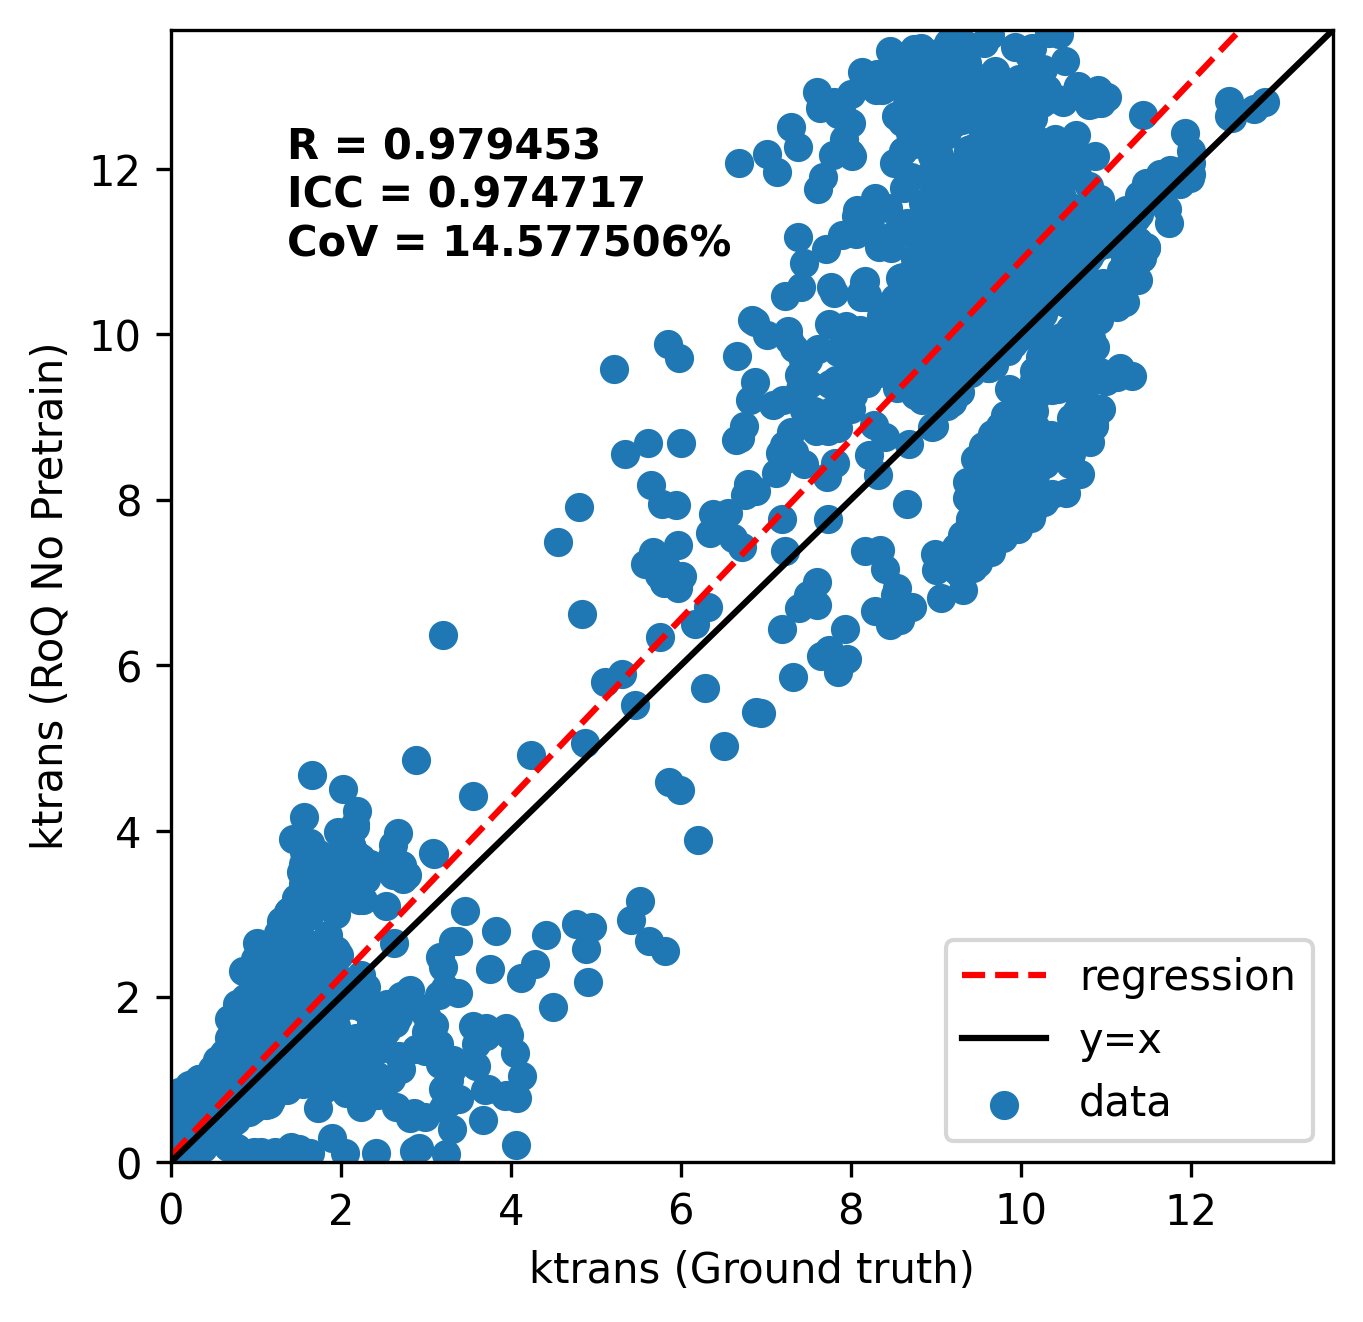

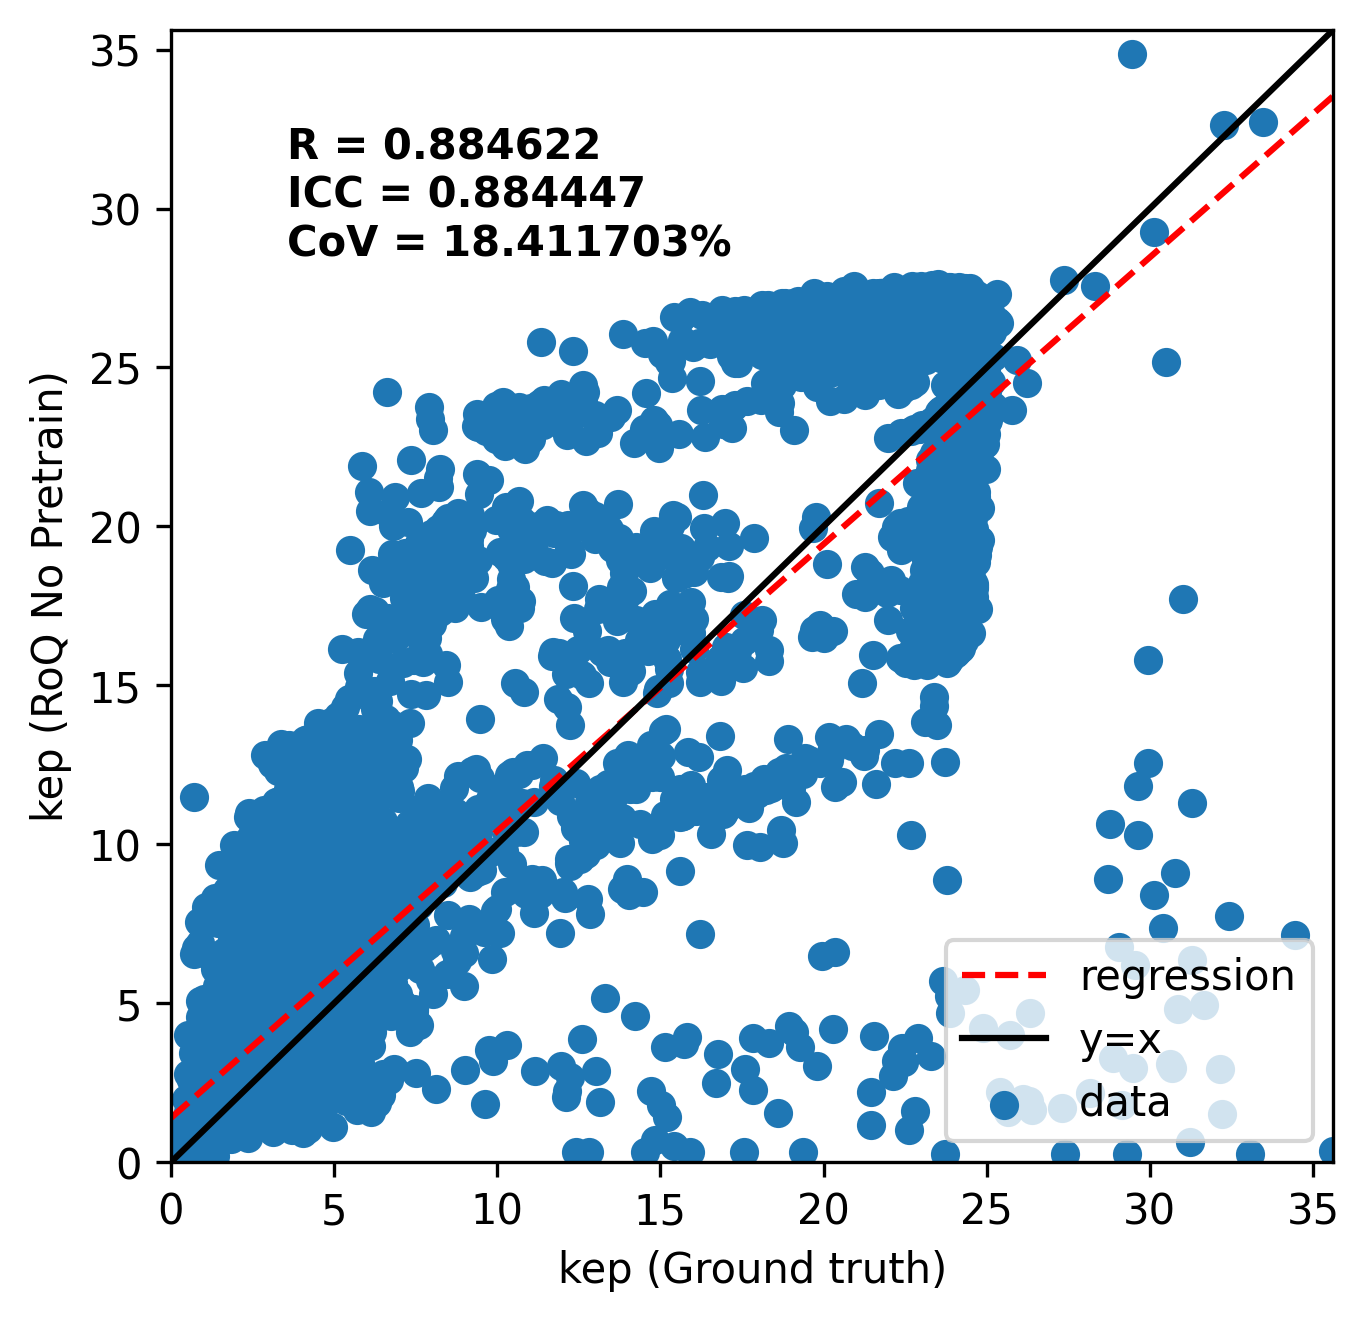

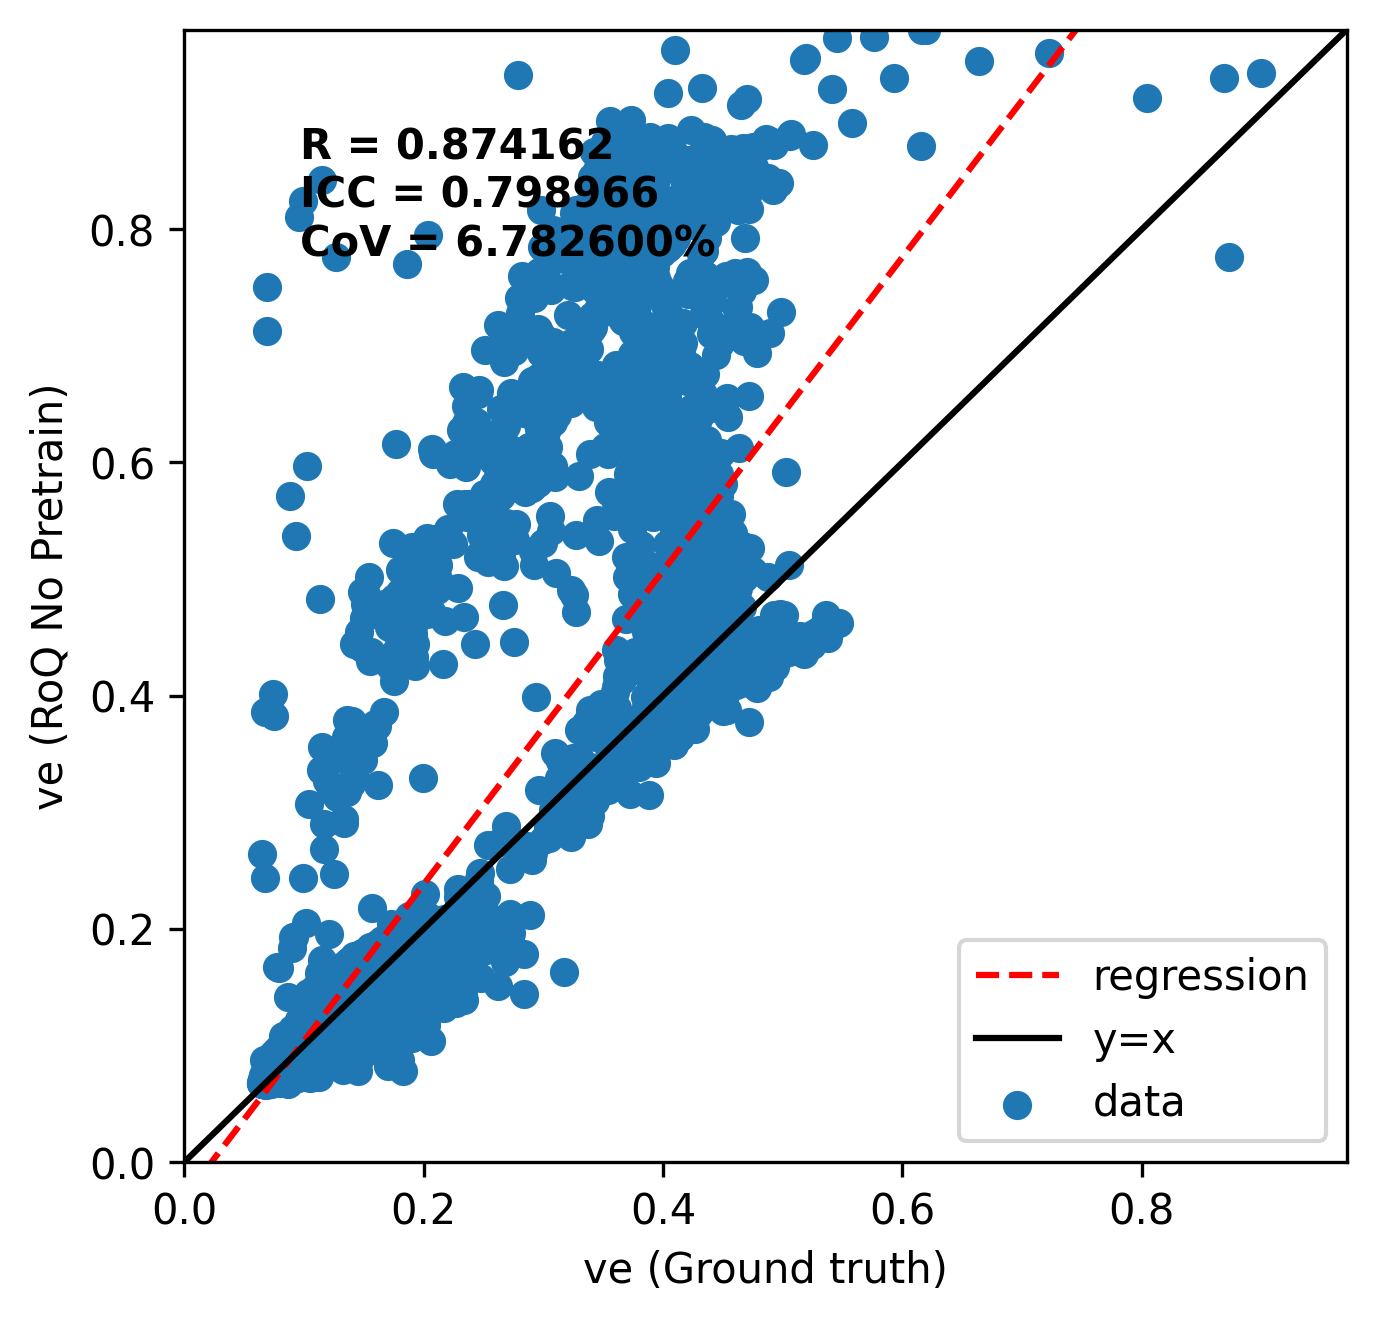

In [9]:

disp_name = {'Ground truth (VARPRO)':pk_gt_varpro,'Ground truth':pk_gt,'Linear Interpolation':pk_lp,'RoQ':pk_roq,'RoQ (VARPRO)':pk_roq_varpro,'RoQ No Pretrain':pk_nopre}
pk_name = {'0':'ktrans','1':'kep','2':'ve'}
savepath = f"/home/chaowei/workspace/RoQ-DCE-DL/results/{prefix}"
for i in range(3):
    for j_name in ['RoQ No Pretrain']:
        smart_mkdir(savepath)
        MyPlot(pk_gt[:,i],disp_name[j_name][:,i],[f"{pk_name[str(i)]} (Ground truth)",f"{pk_name[str(i)]} ({j_name})"],np.max((pk_gt[:,i],disp_name[j_name][:,i])),savepath,f"{pk_name[str(i)]}_{j_name}",mode='do')

(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)


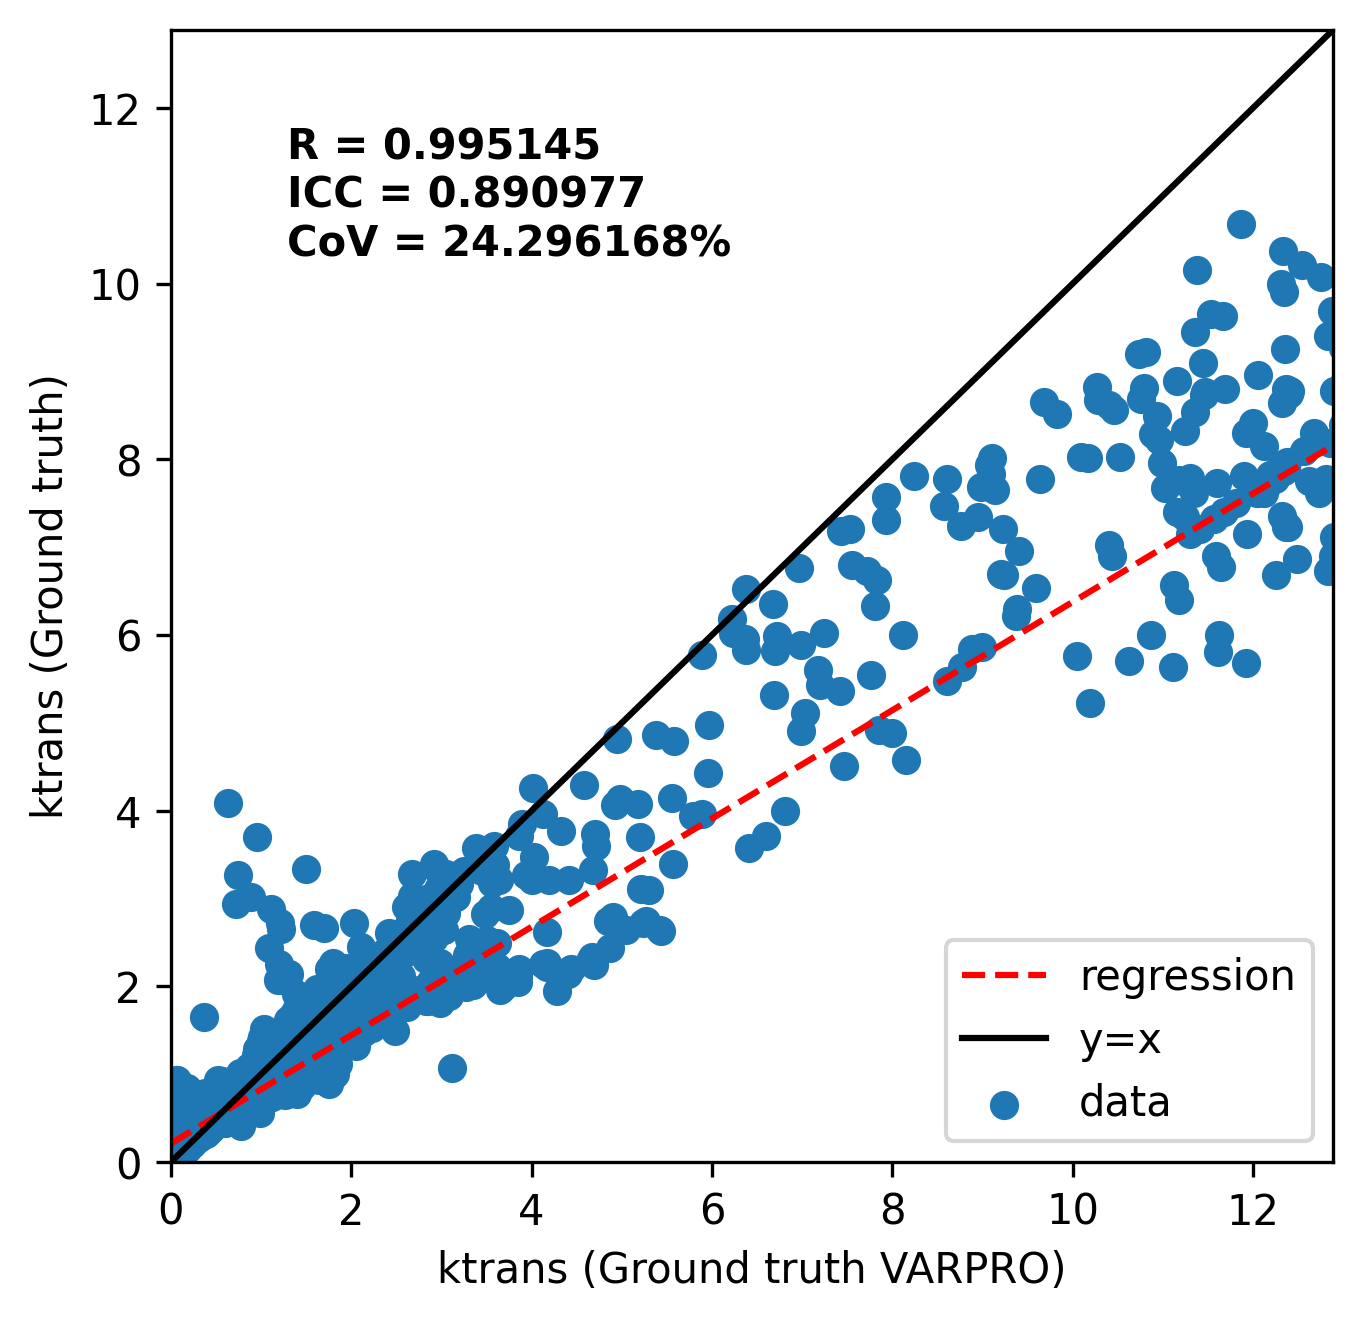

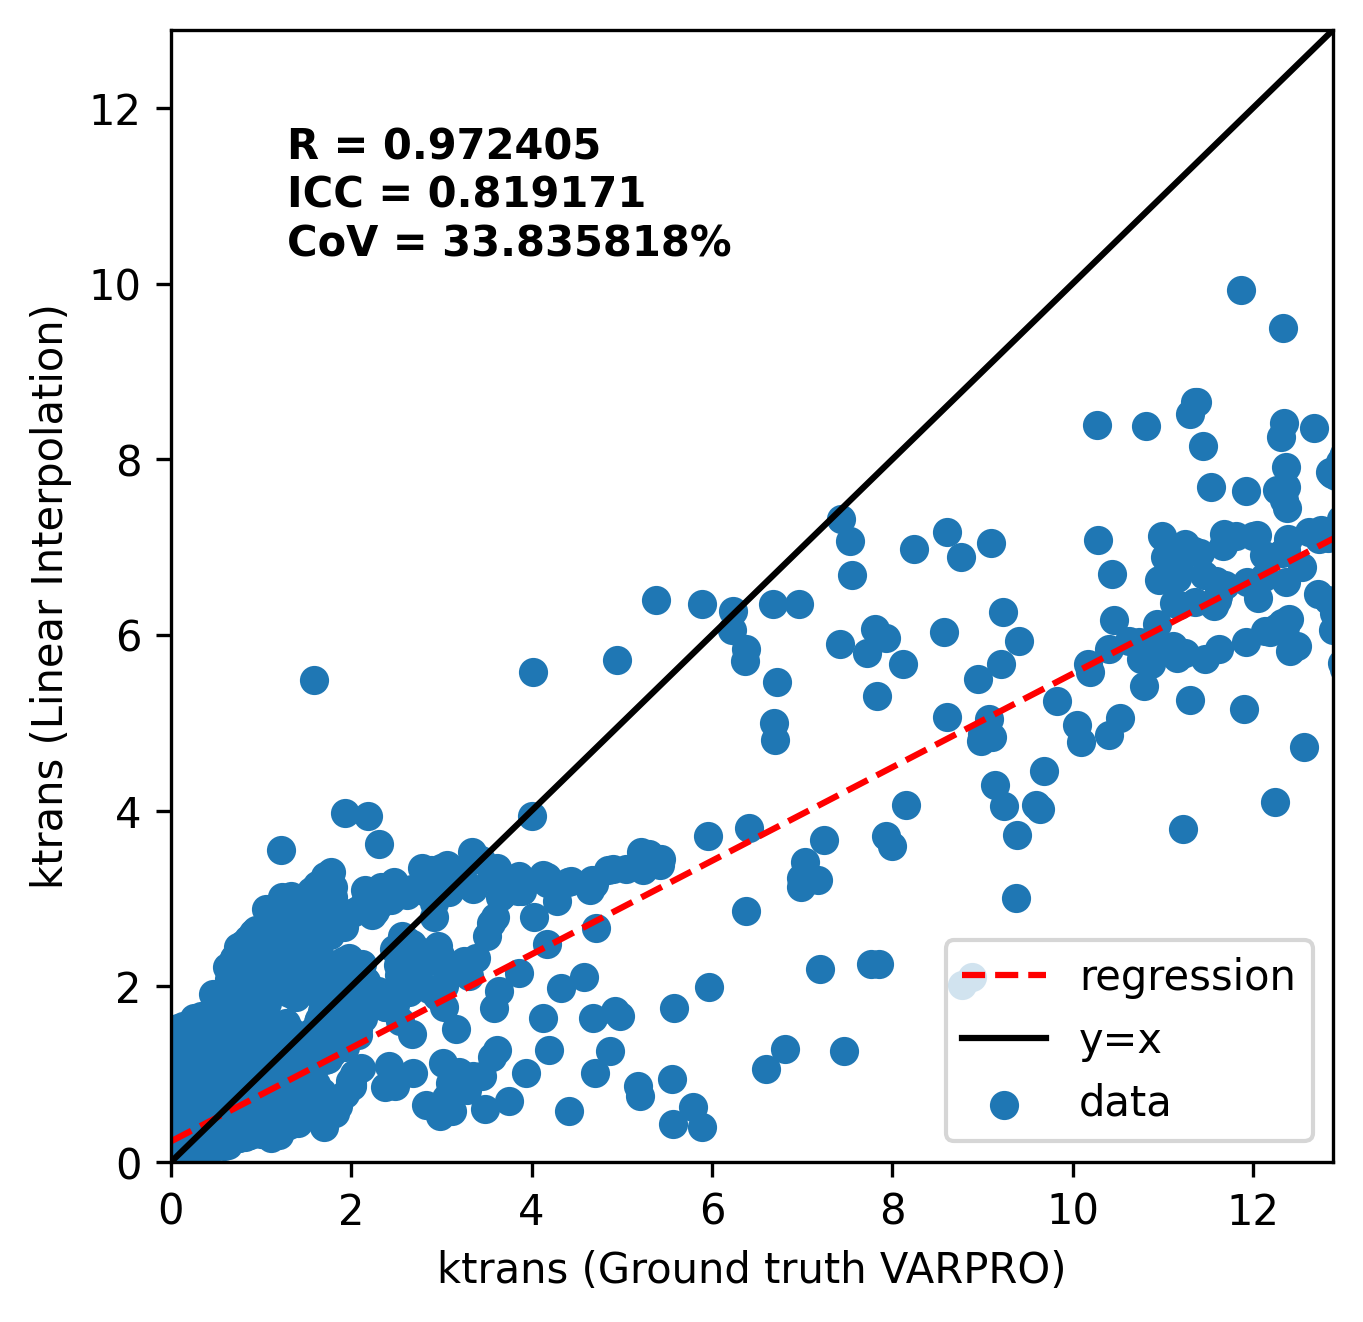

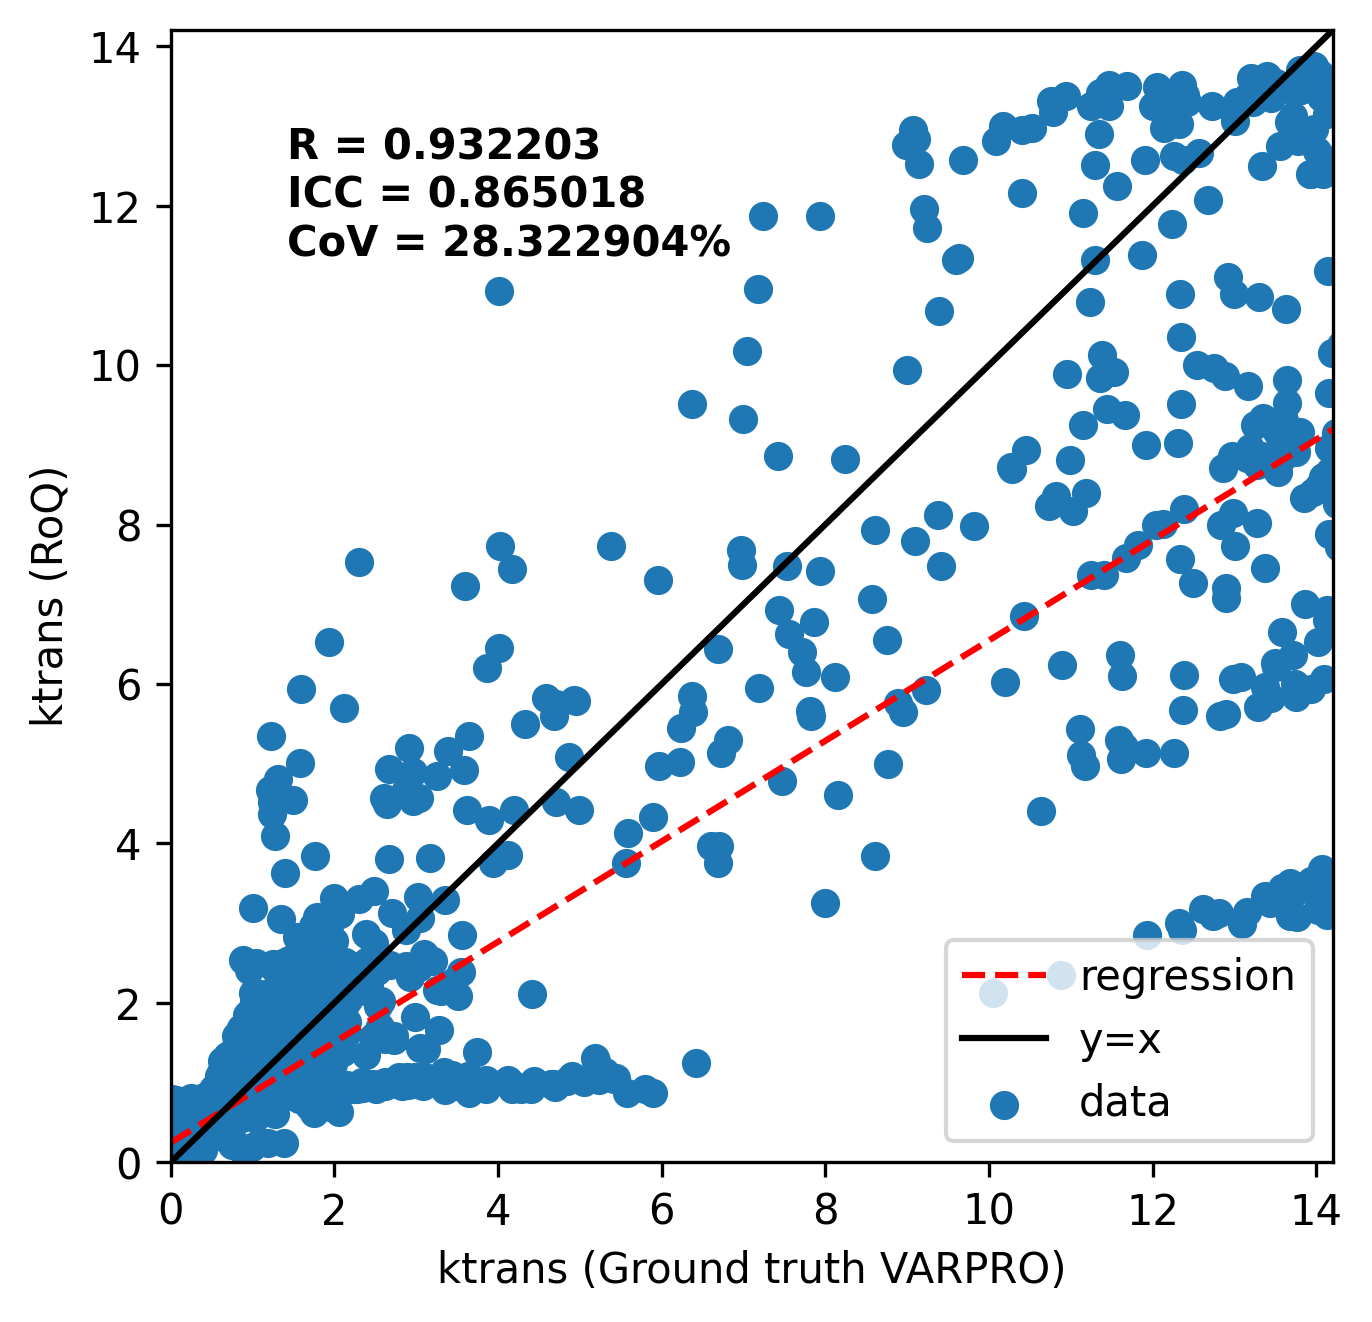

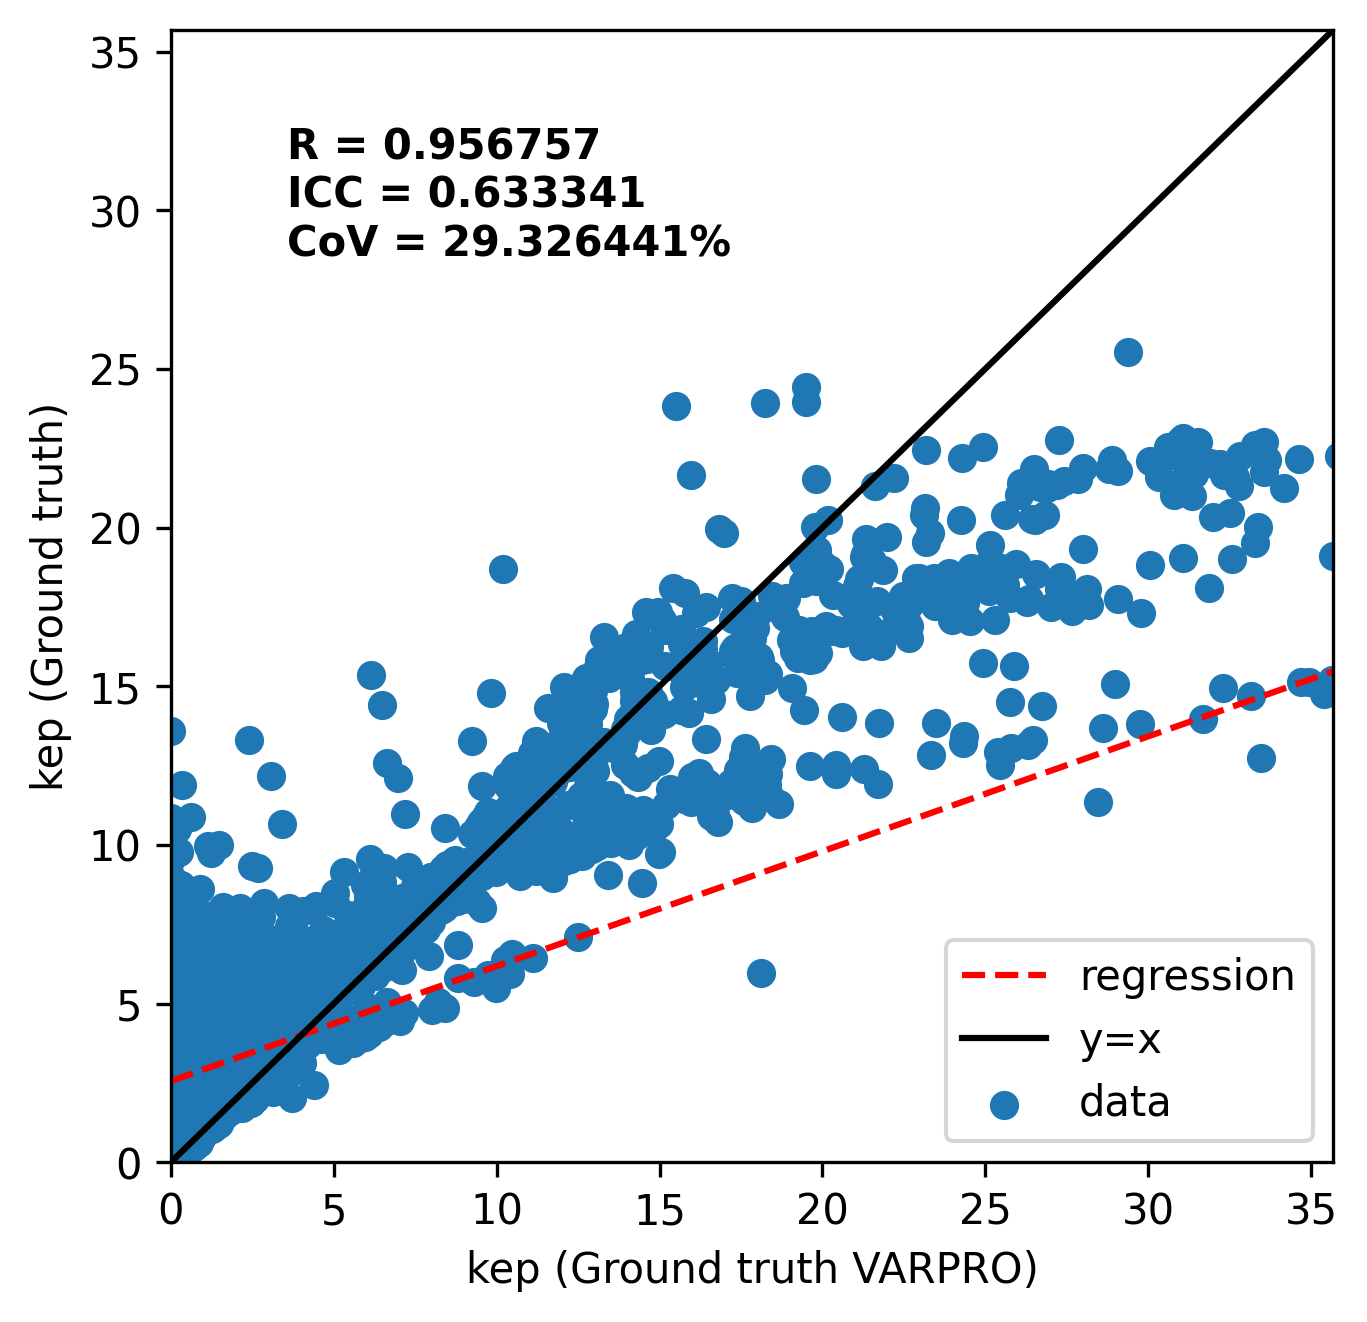

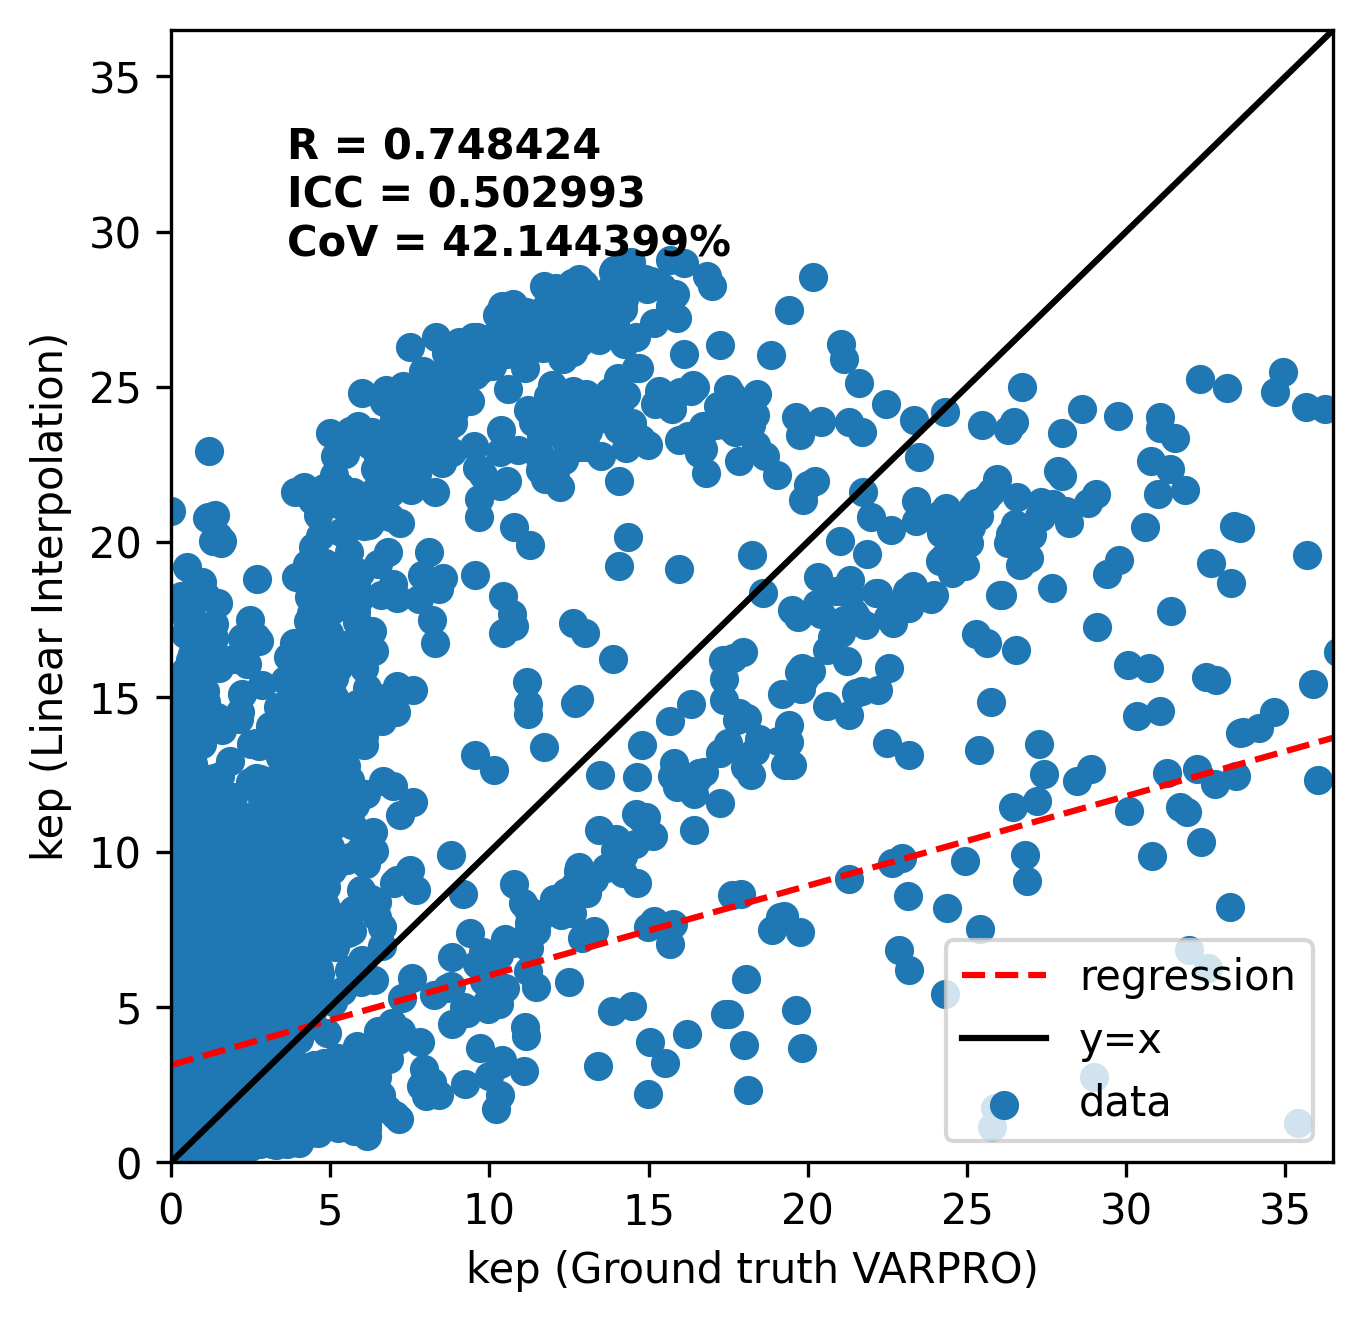

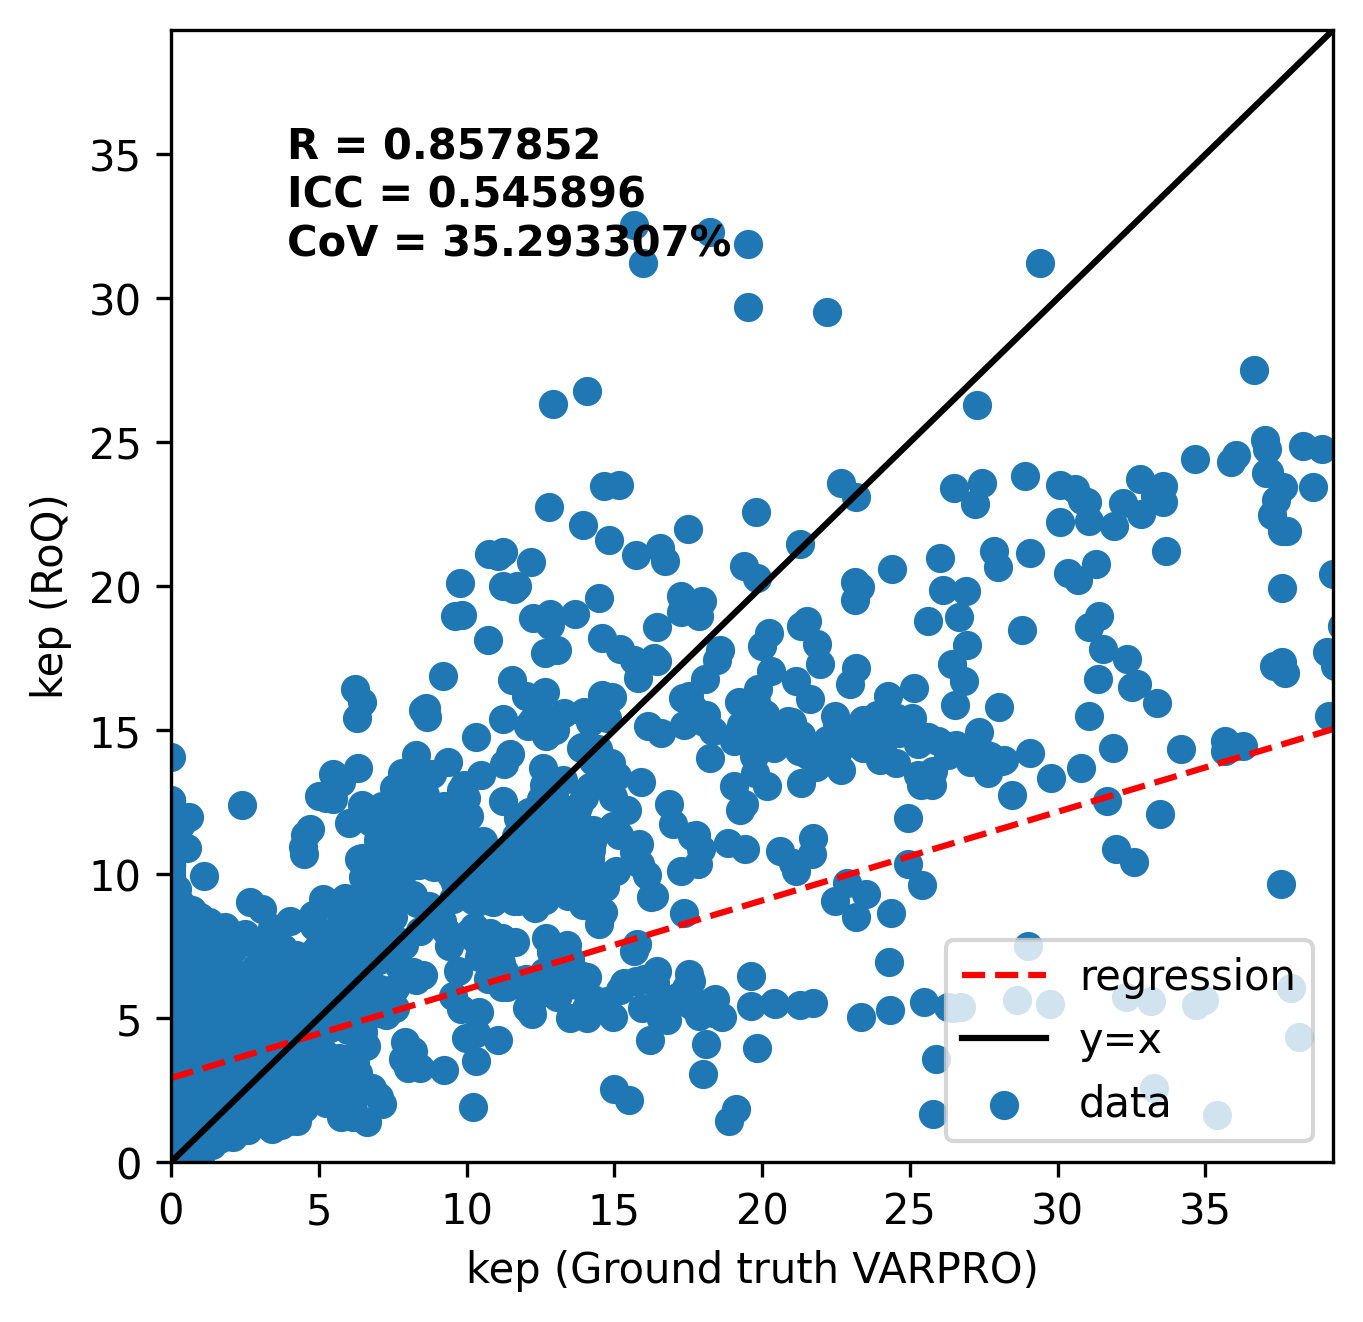

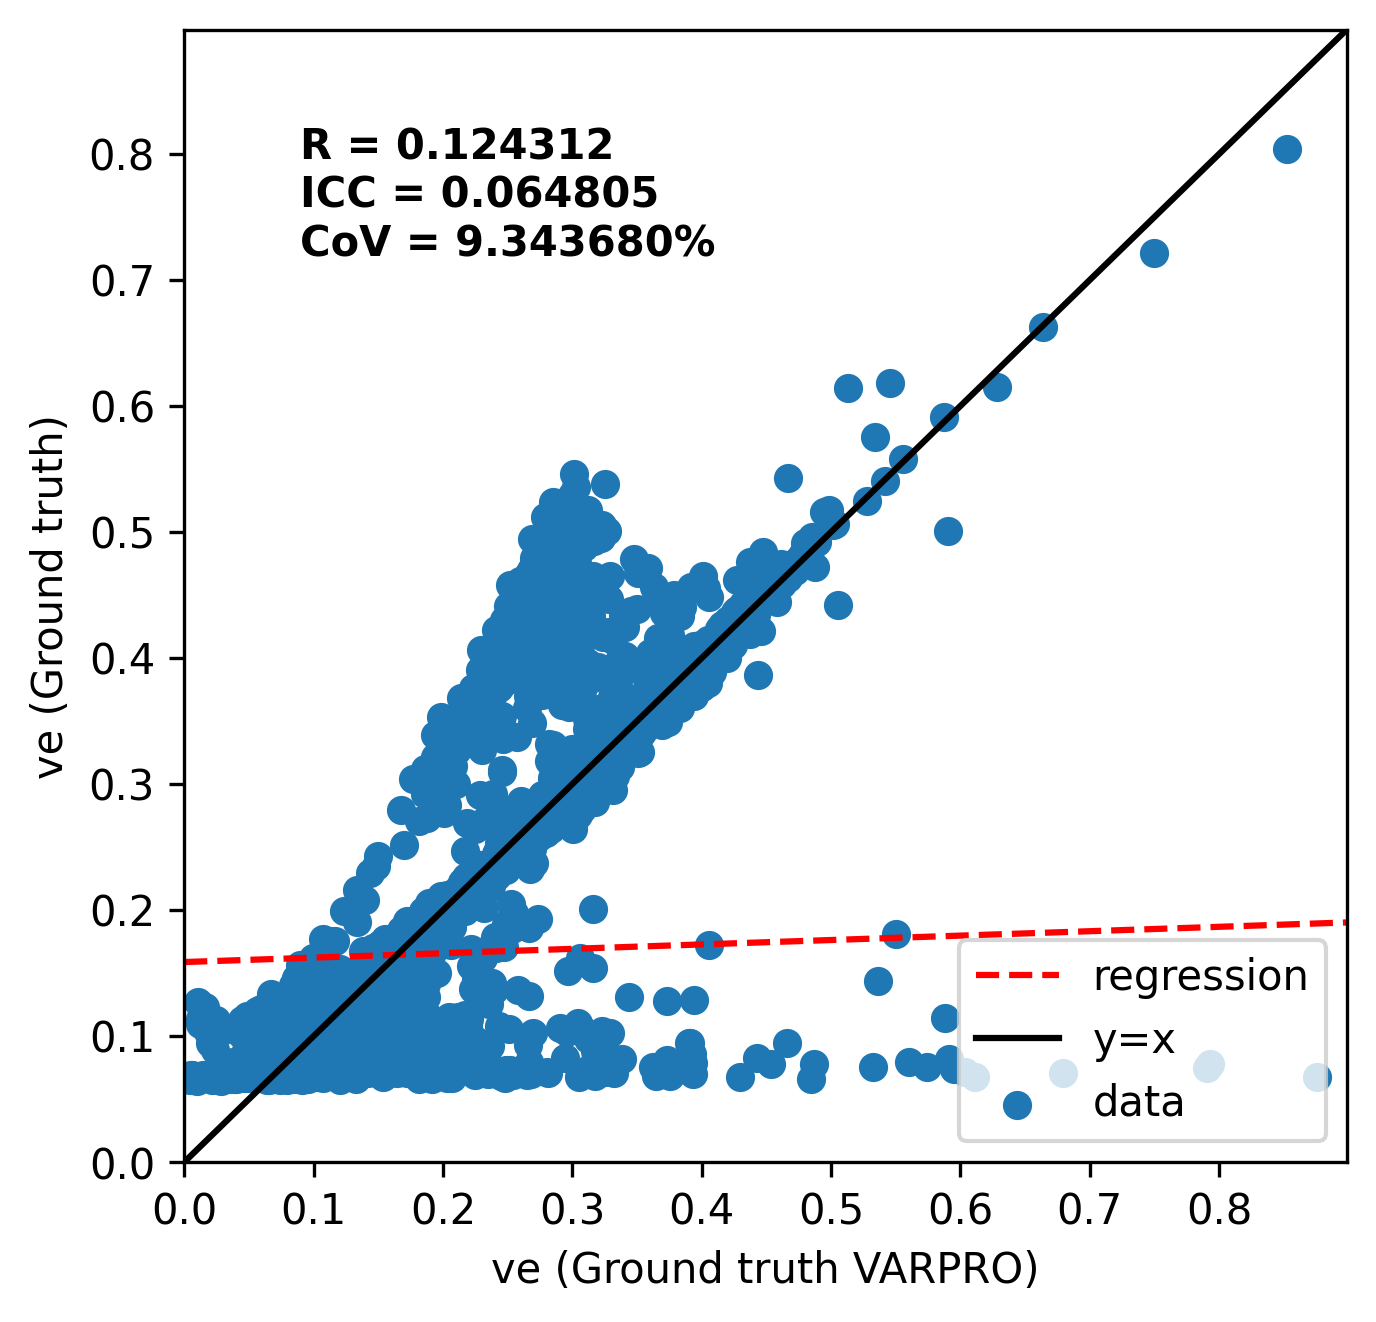

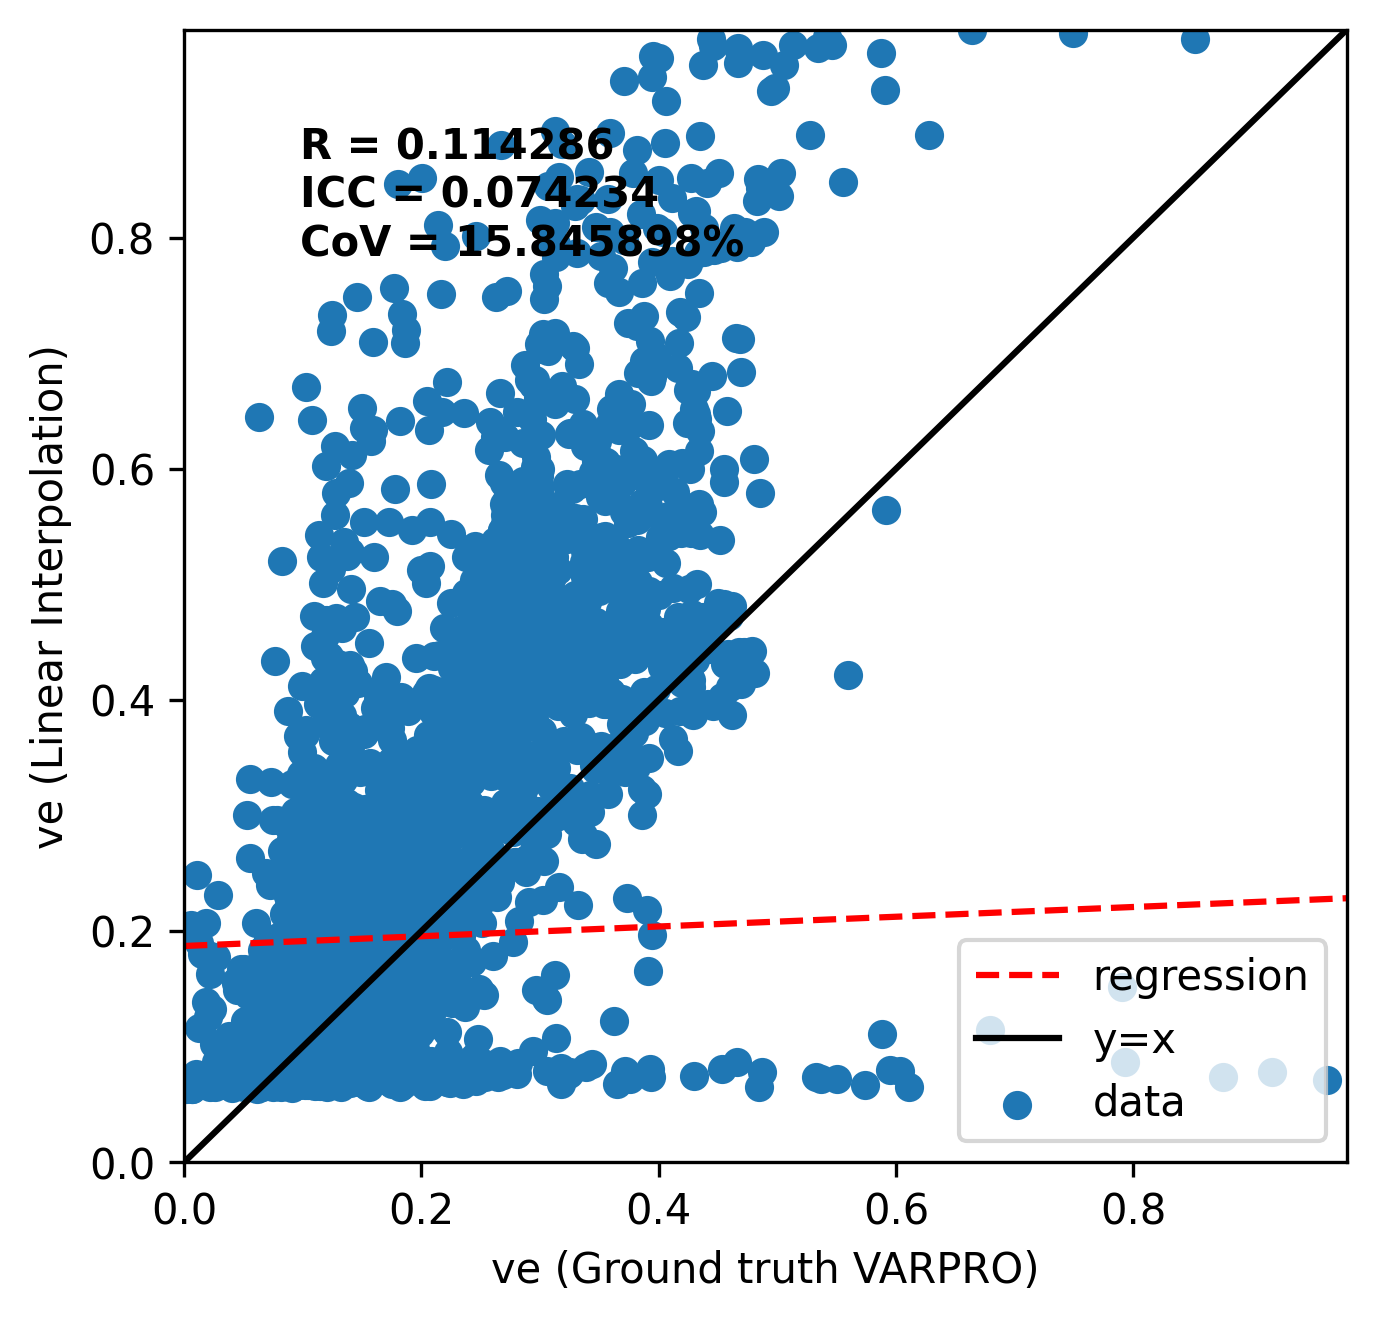

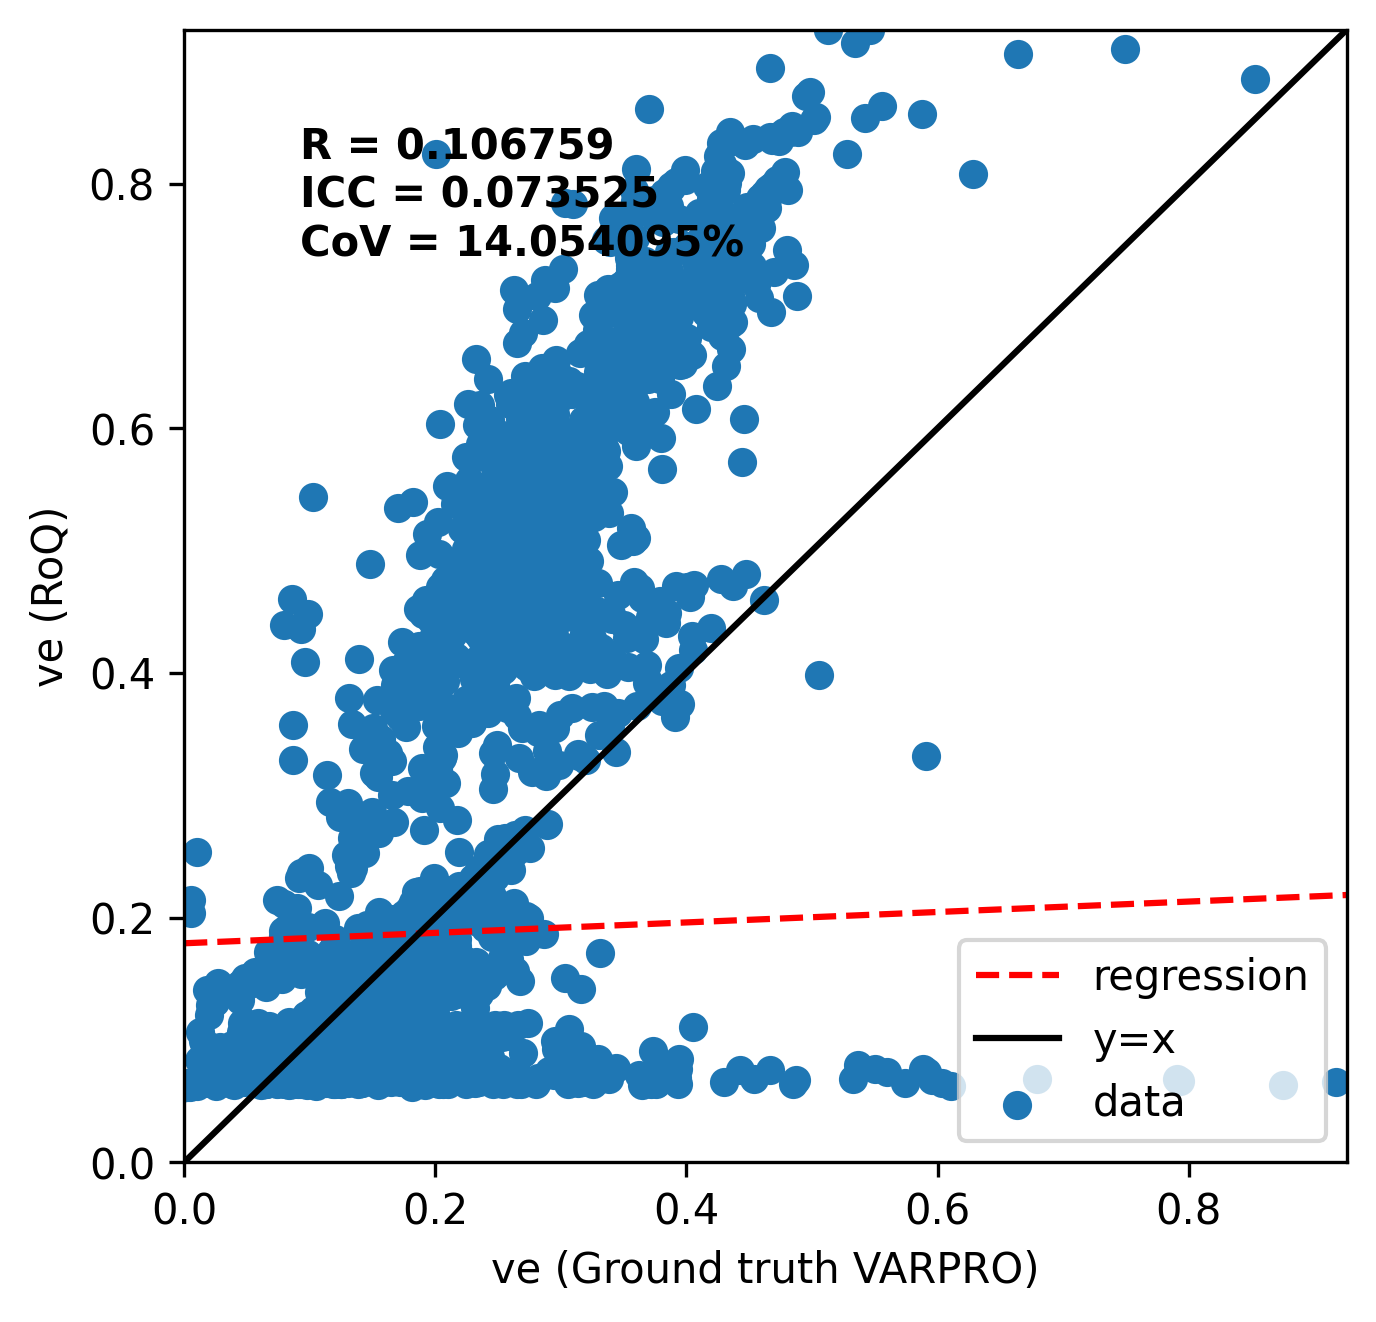

In [25]:

disp_name = {'Ground truth (VARPRO)':pk_gt_varpro,'Ground truth':pk_gt,'Linear Interpolation':pk_lp,'RoQ':pk_roq,'RoQ (VARPRO)':pk_roq_varpro}
pk_name = {'0':'ktrans','1':'kep','2':'ve'}
savepath = f"/home/chaowei/workspace/RoQ-DCE-DL/results/{prefix}"
for i in range(3):
    for j_name in ['Ground truth','Linear Interpolation','RoQ']:
        smart_mkdir(savepath)
        MyPlot(pk_gt_varpro[:,i],disp_name[j_name][:,i],[f"{pk_name[str(i)]} (Ground truth VARPRO)",f"{pk_name[str(i)]} ({j_name})"],np.max((pk_gt[:,i],disp_name[j_name][:,i])),savepath,f"{pk_name[str(i)]}_{j_name}_varpro",mode='do')

(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)


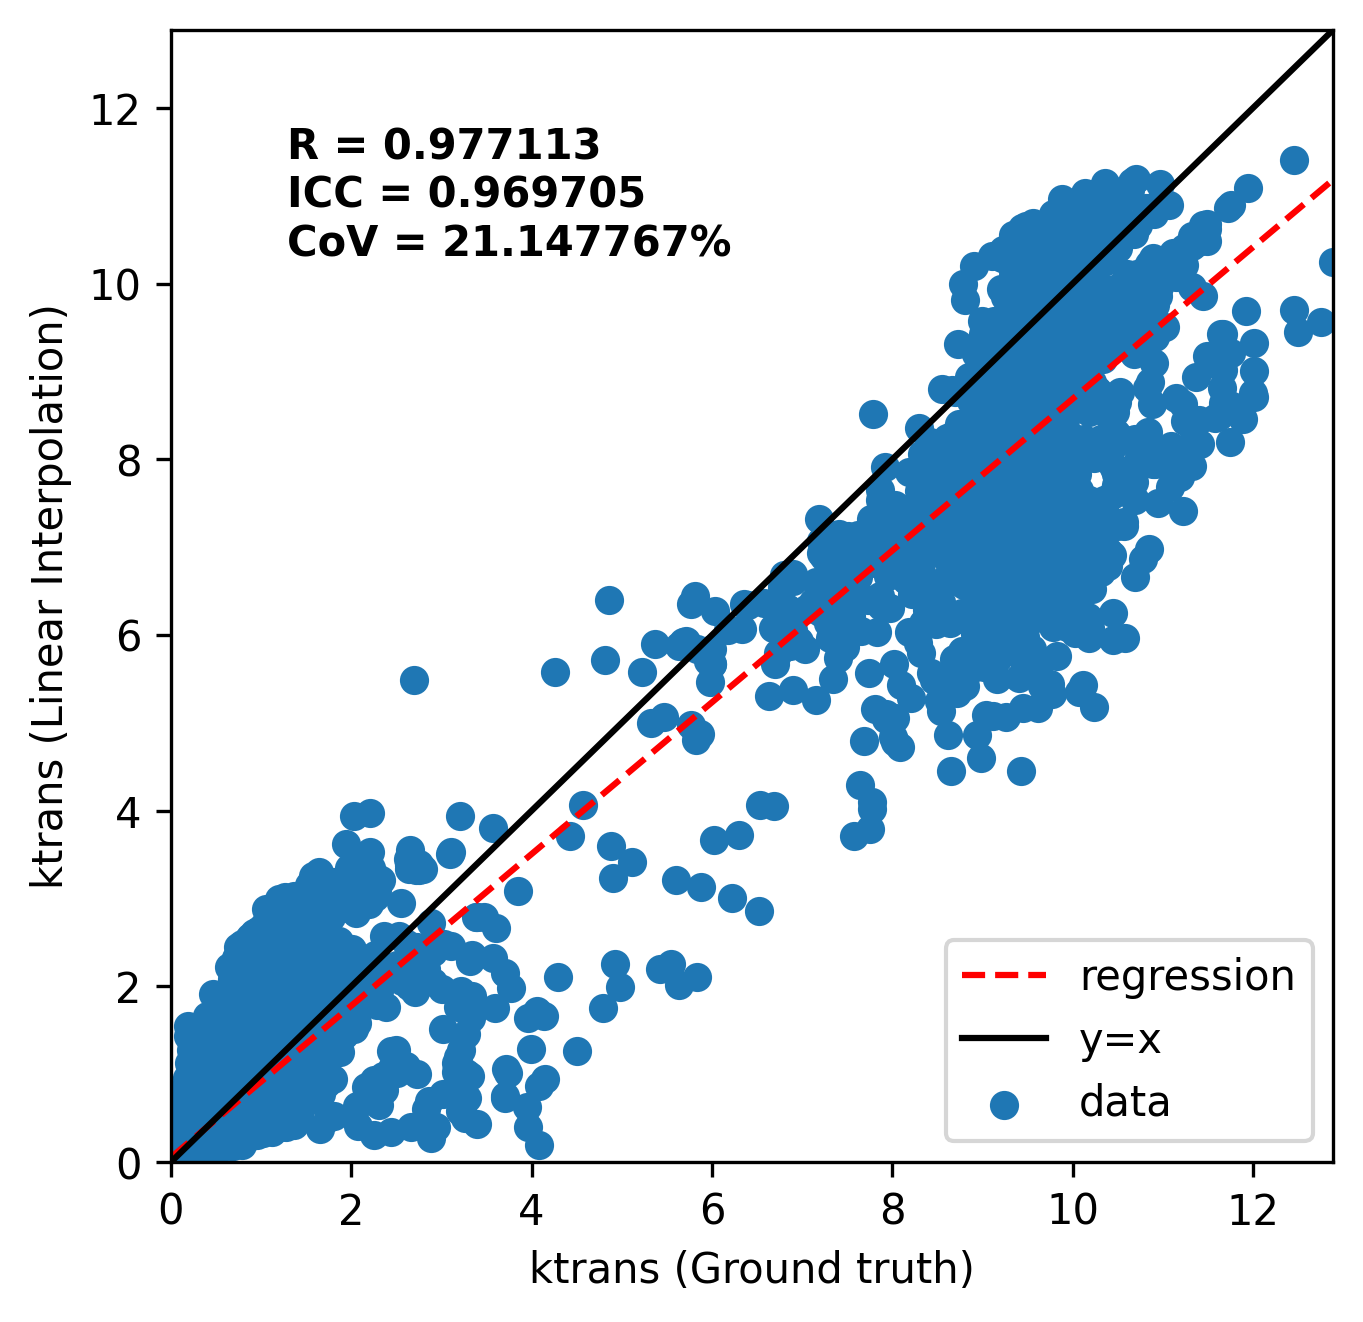

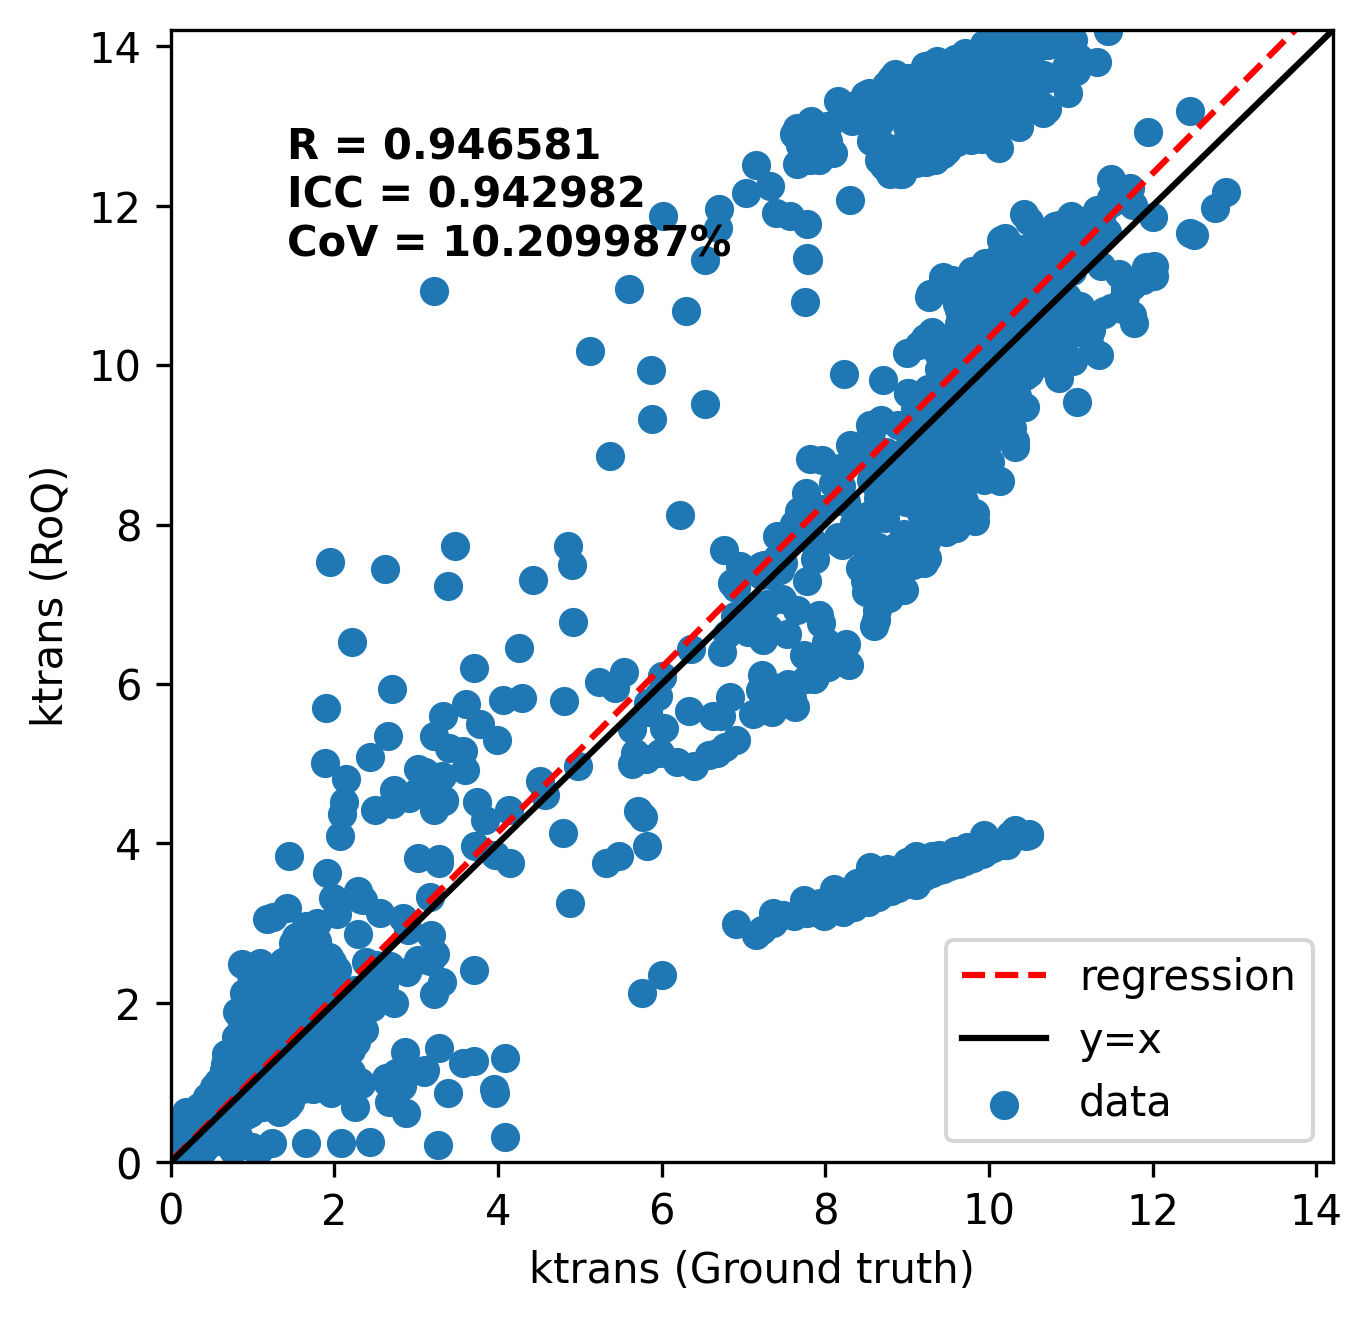

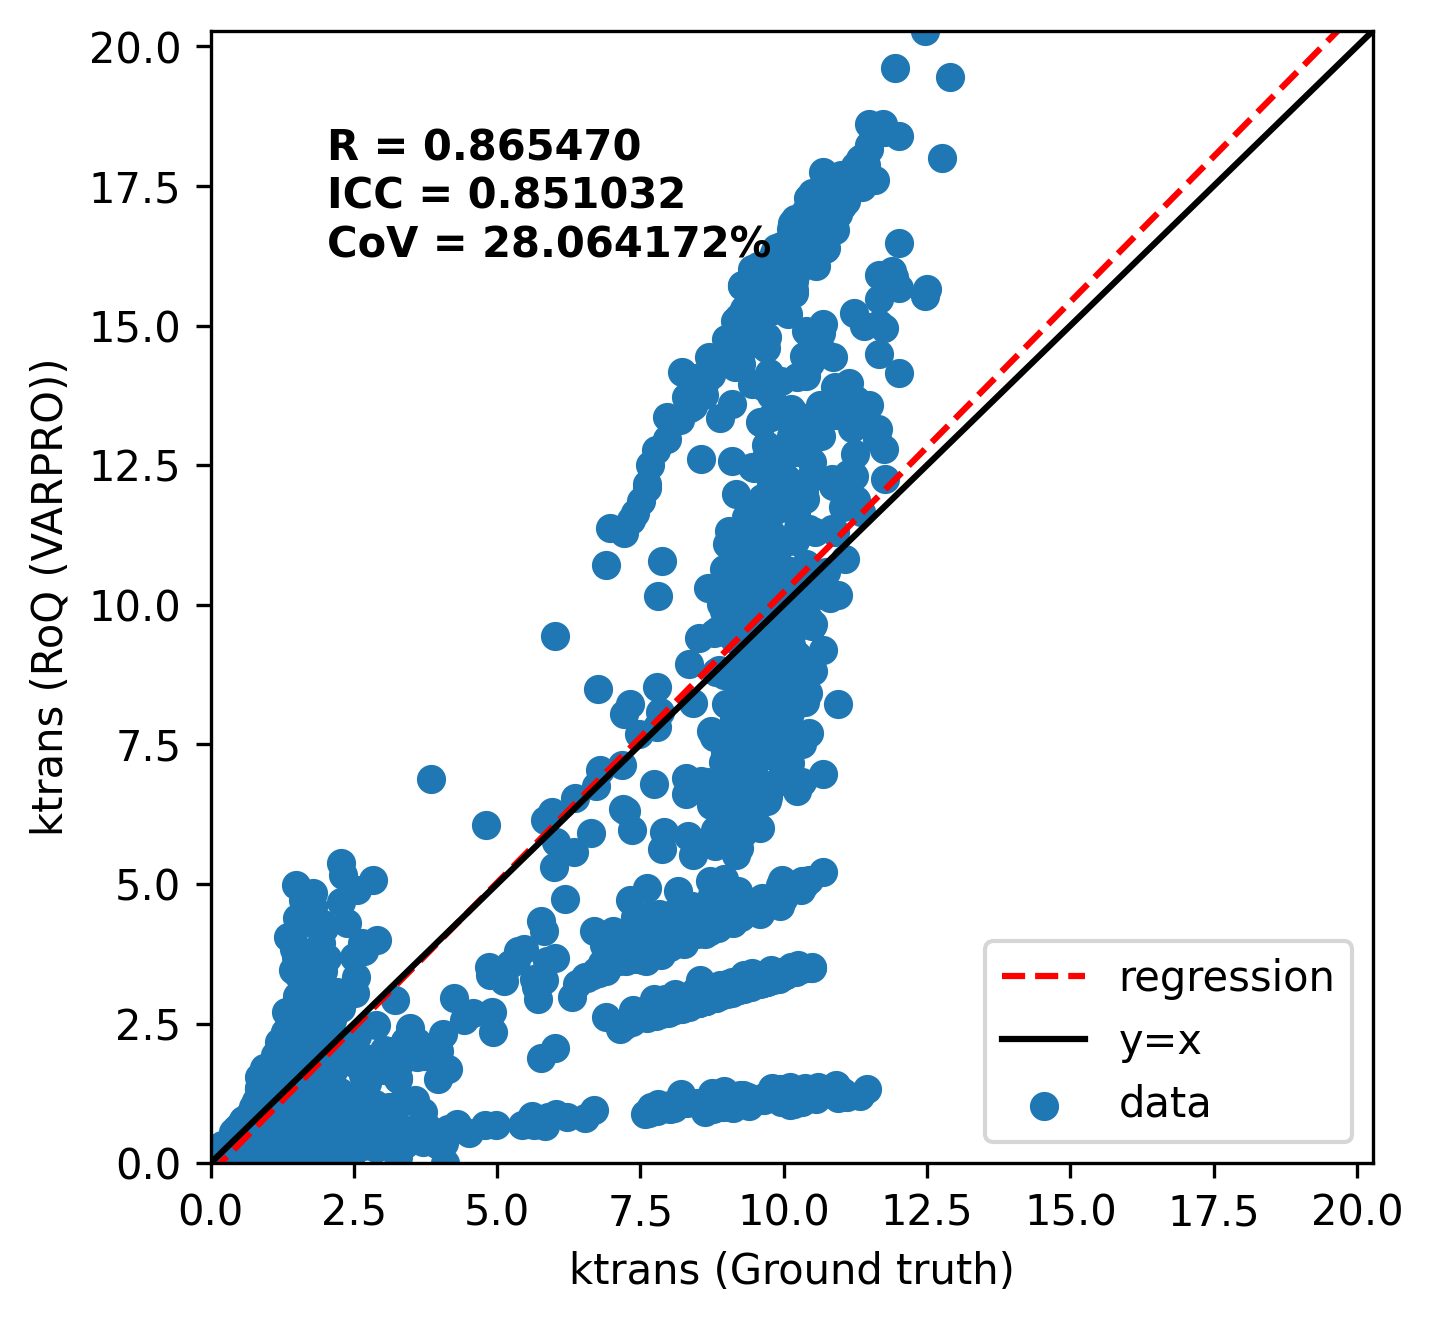

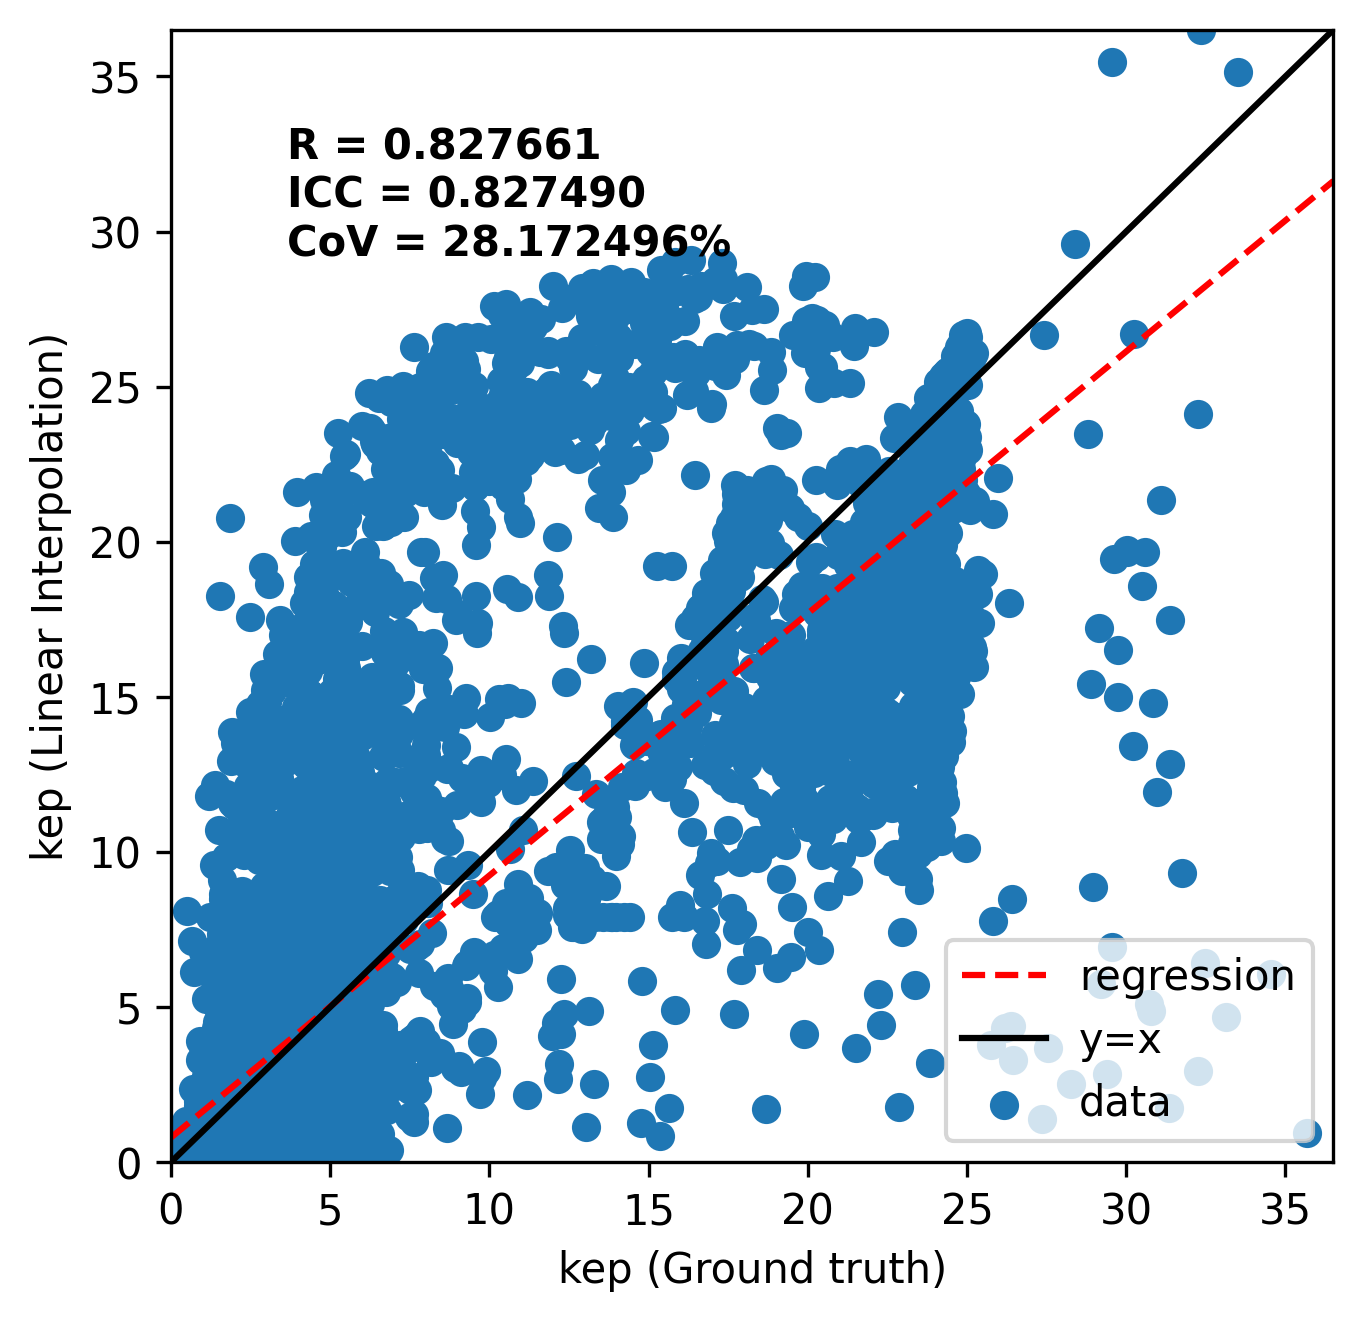

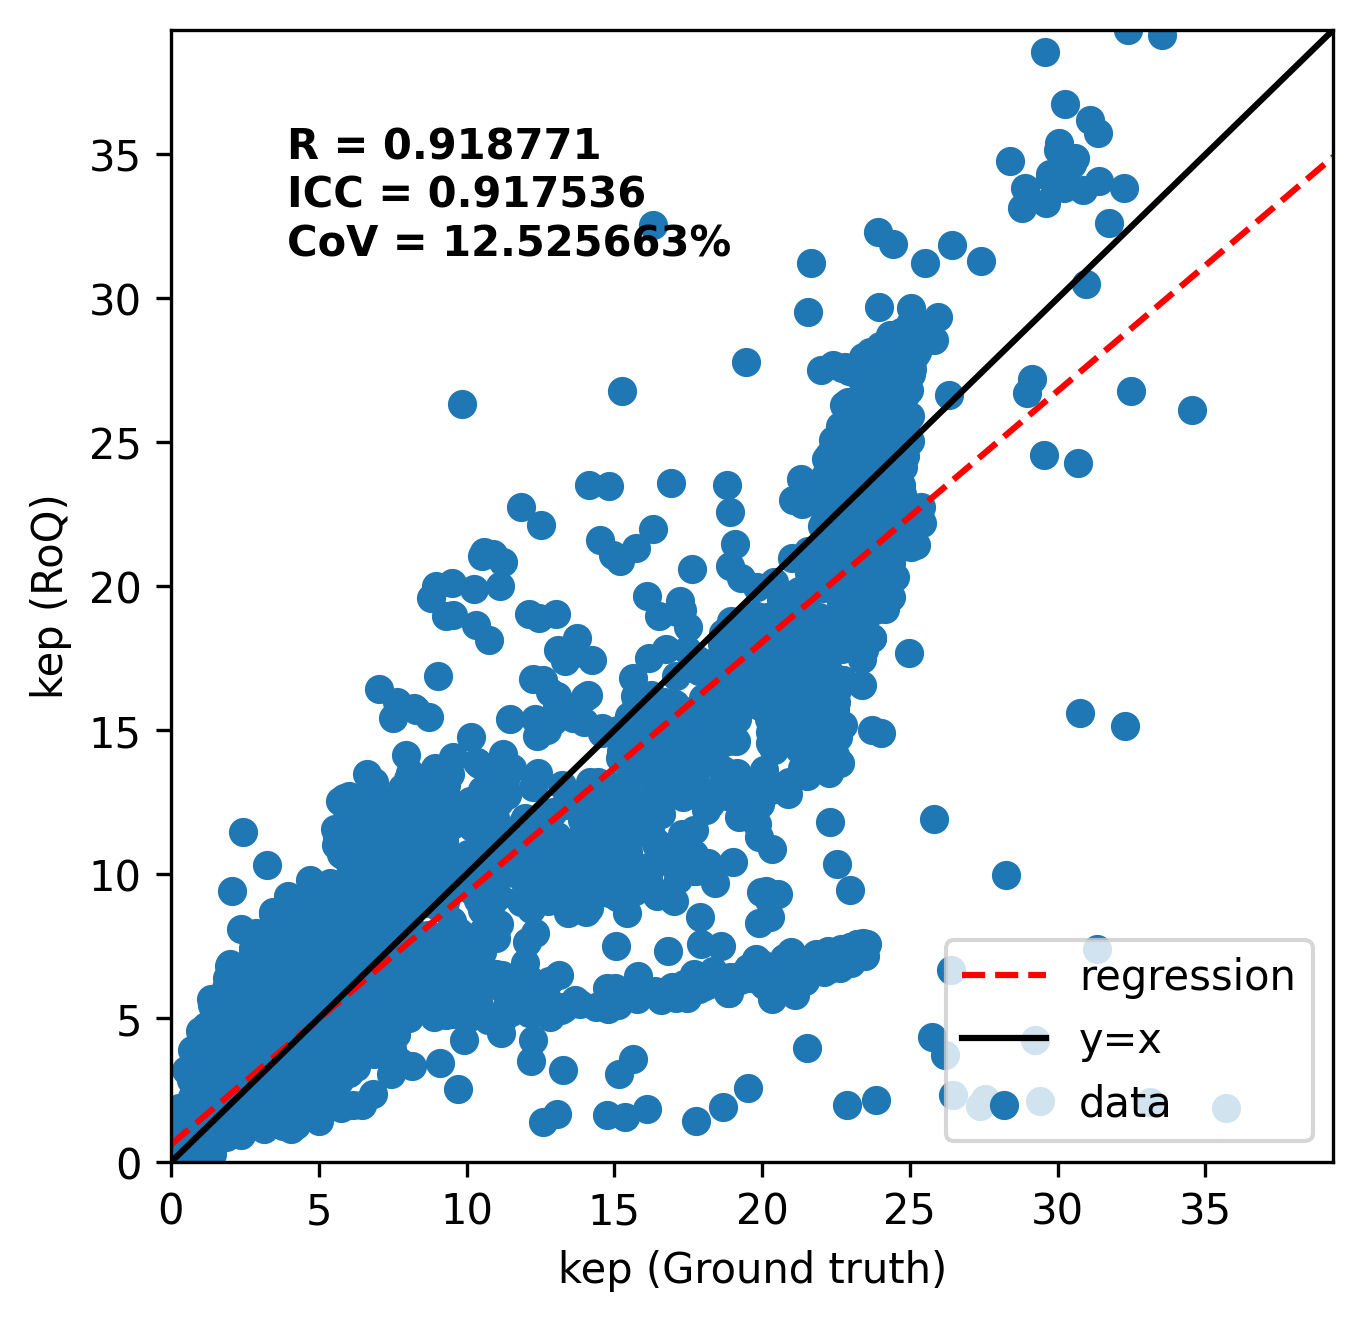

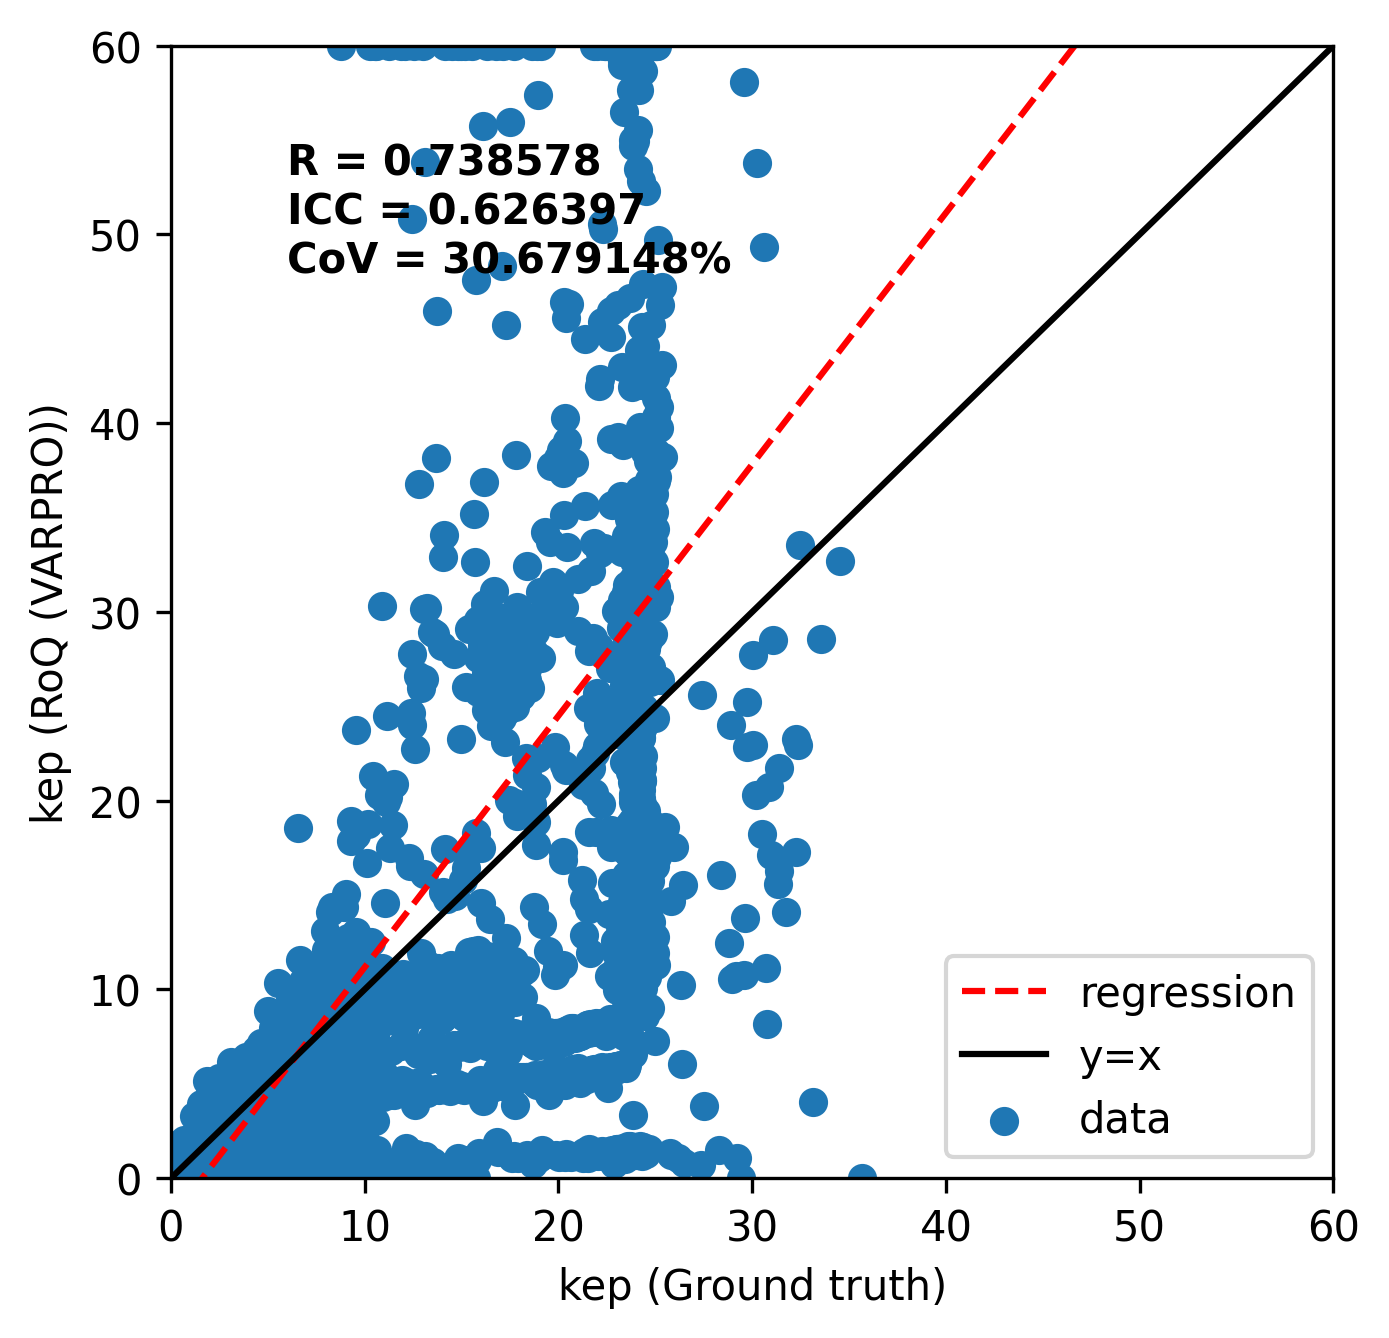

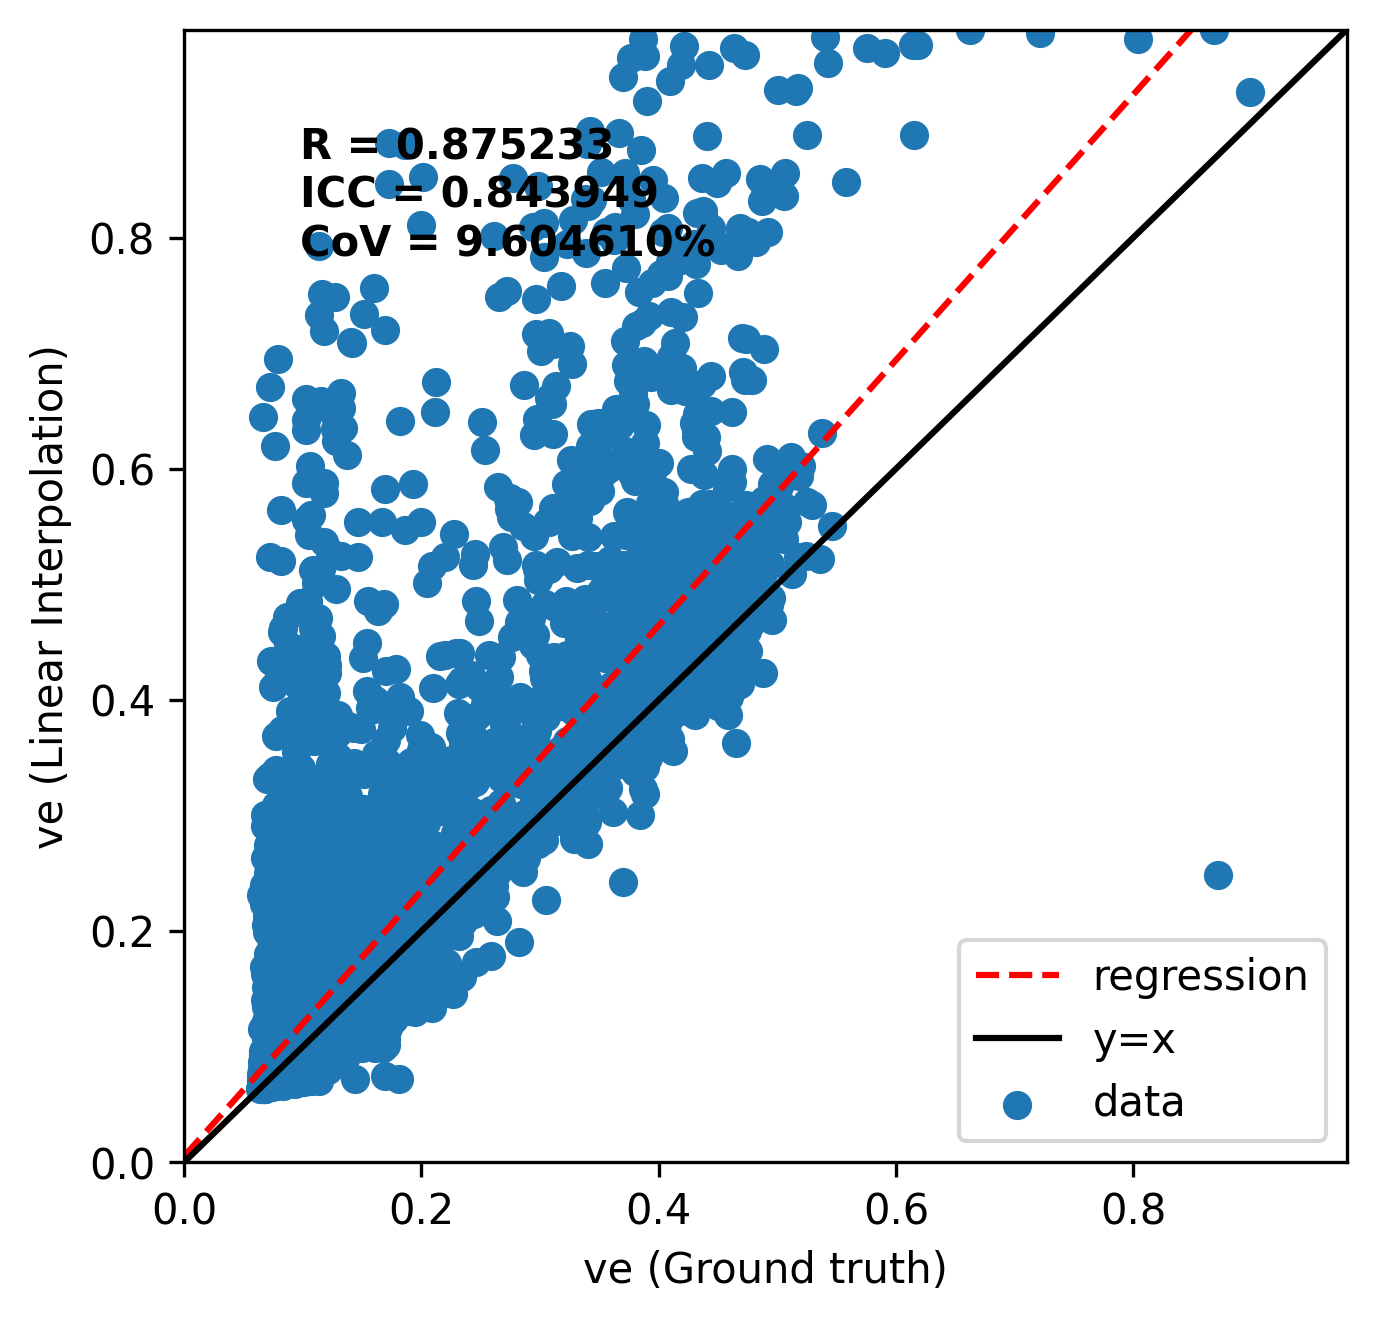

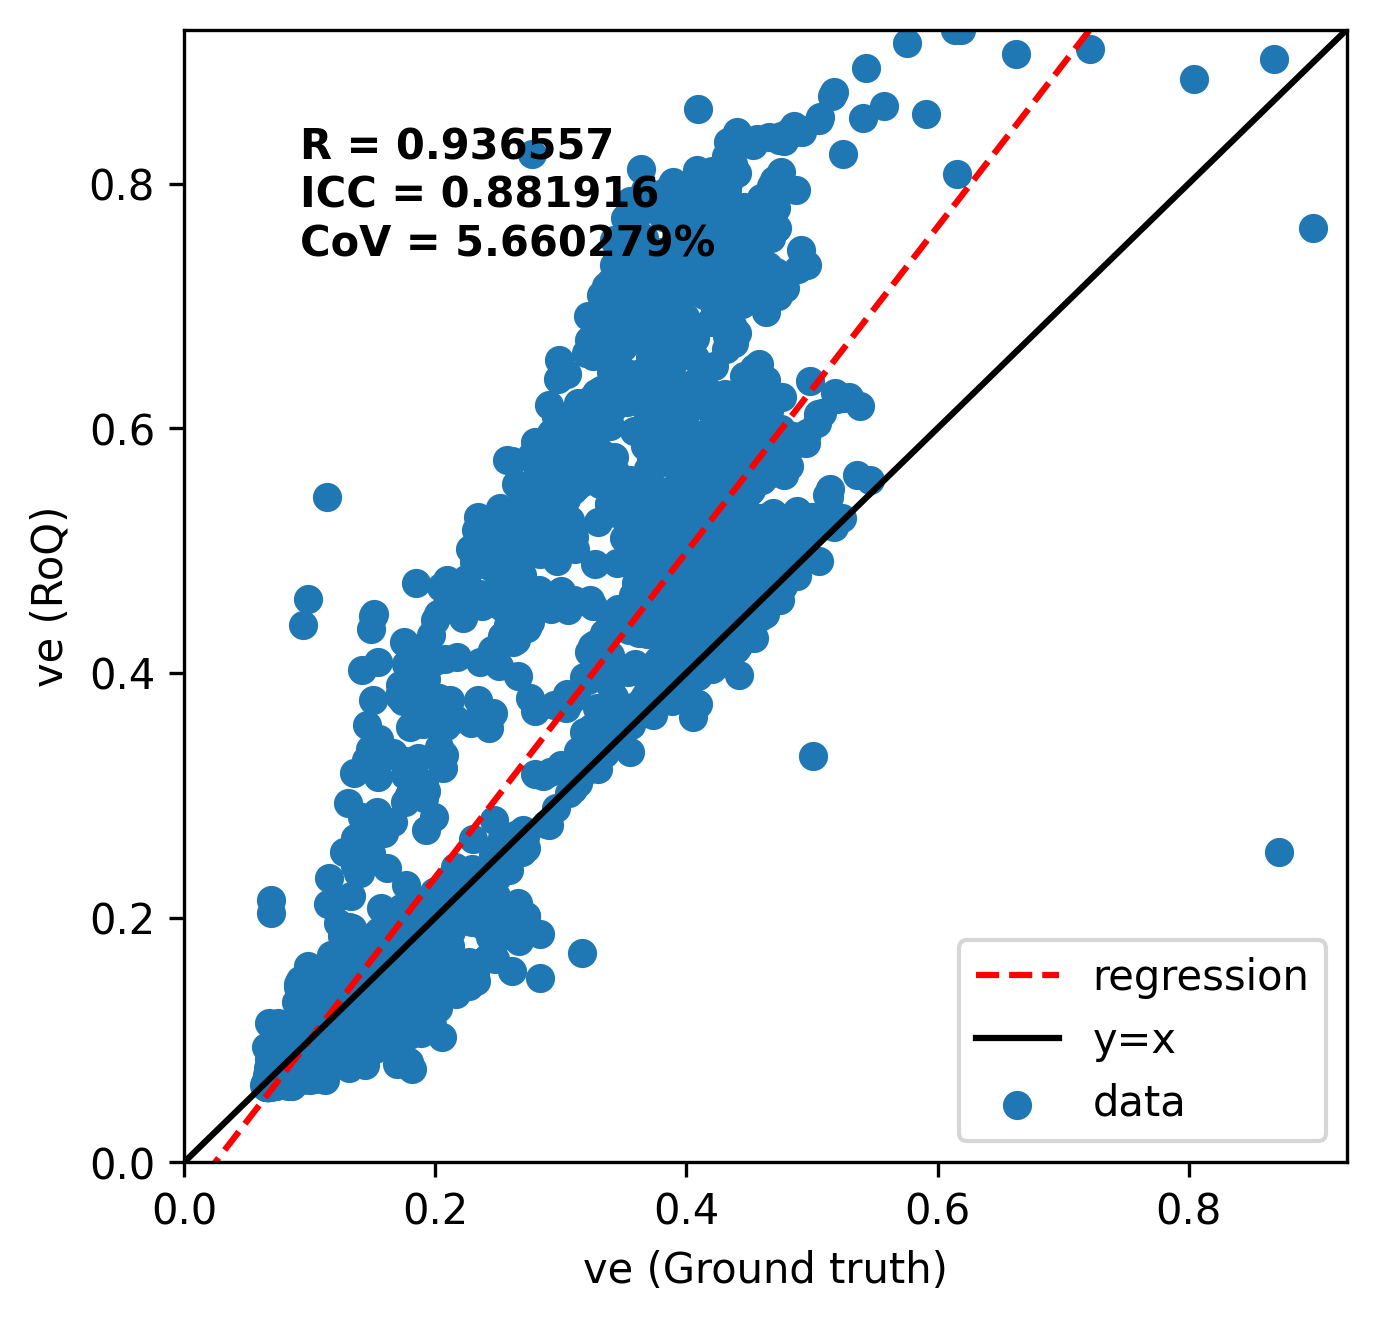

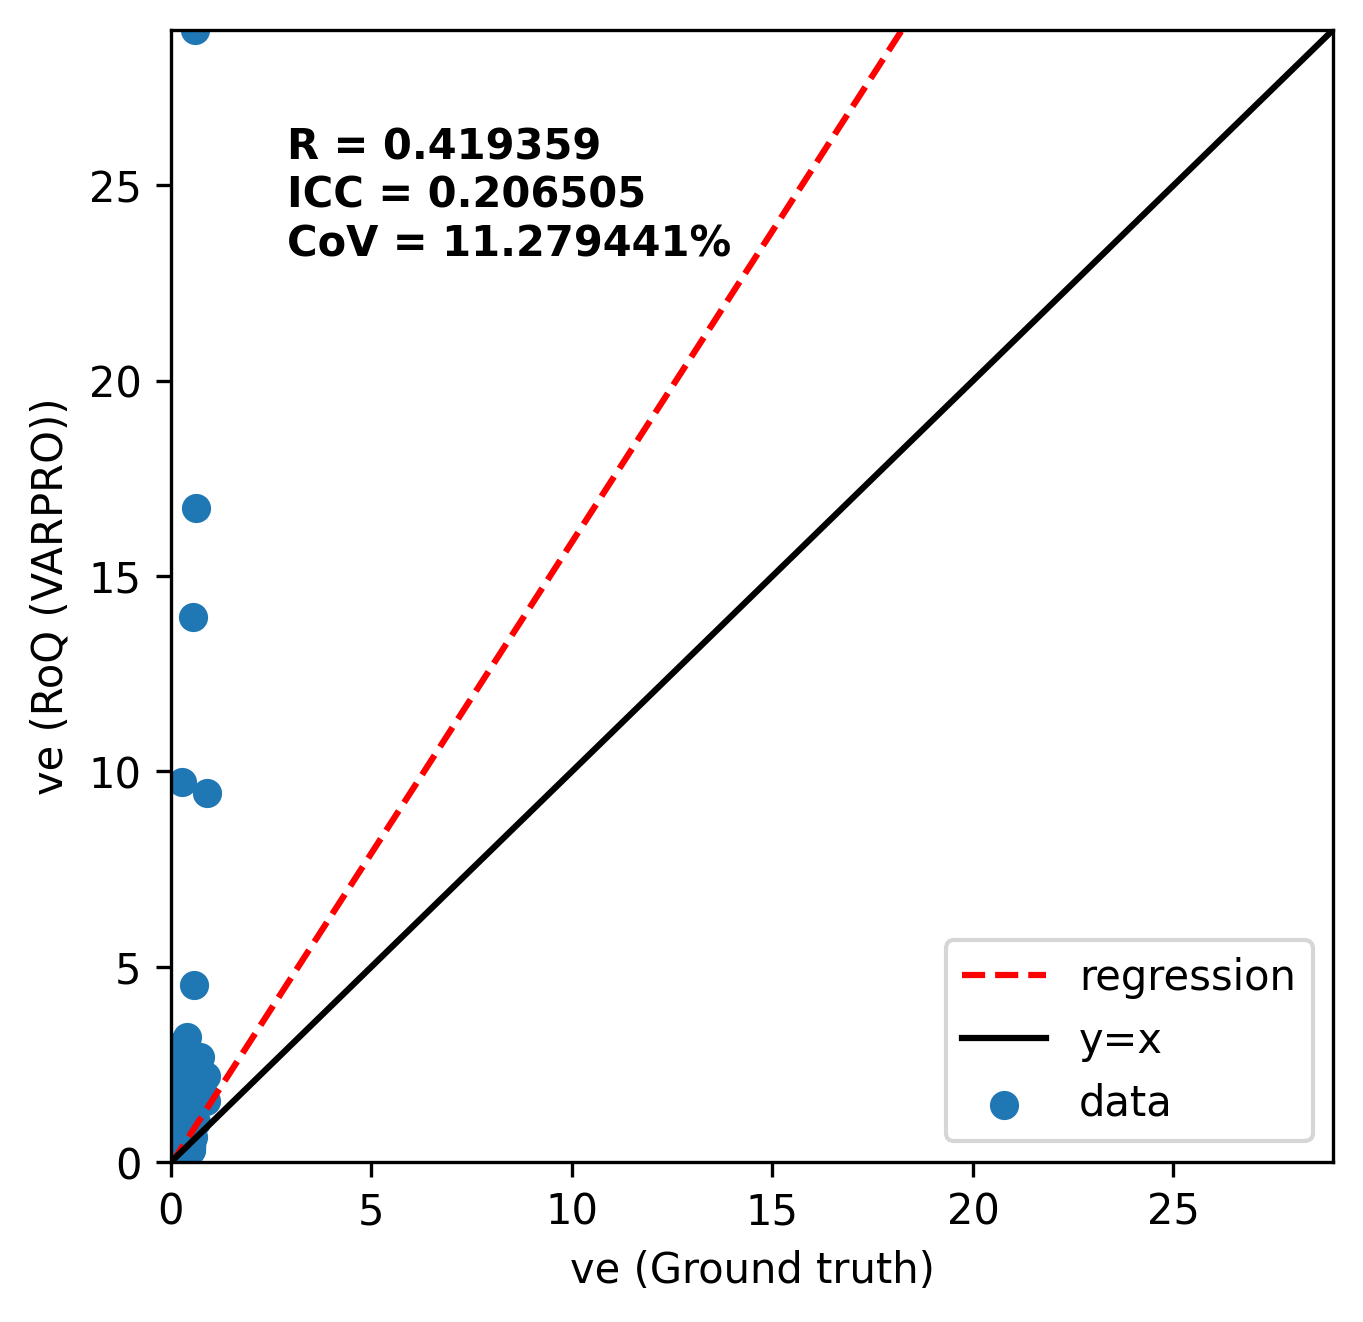

In [26]:
mode='do'
MyPlot(pfit_test[:,2],pfit_pred[:,2],["Ve (Groundtruth)","Ve (Retro-Estimated)"],np.max([pfit_pred[:,2],pfit_test[:,2]]),savefolder,'Vp_pd_Tofts_refit_mPM',mode=mode)
MyPlot(60*pfit_test[:,0],60*pfit_pred[:,0],["Ktrans (Groundtruth)","Ktrans (Retro-Estimated)"],60*np.max([pfit_pred[:,0],pfit_test[:,0]]),savefolder,'Ktrans_pd_Tofts_refit_mPM',mode=mode)
MyPlot(60*pfit_test[:,1],60*pfit_pred[:,1],["kep (Groundtruth)","kep (Retro-Estimated)"],60*np.max([pfit_pred[:,1],pfit_test[:,1]]),savefolder,'kep_pd_Tofts_refit_mPM',mode=mode)



(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)


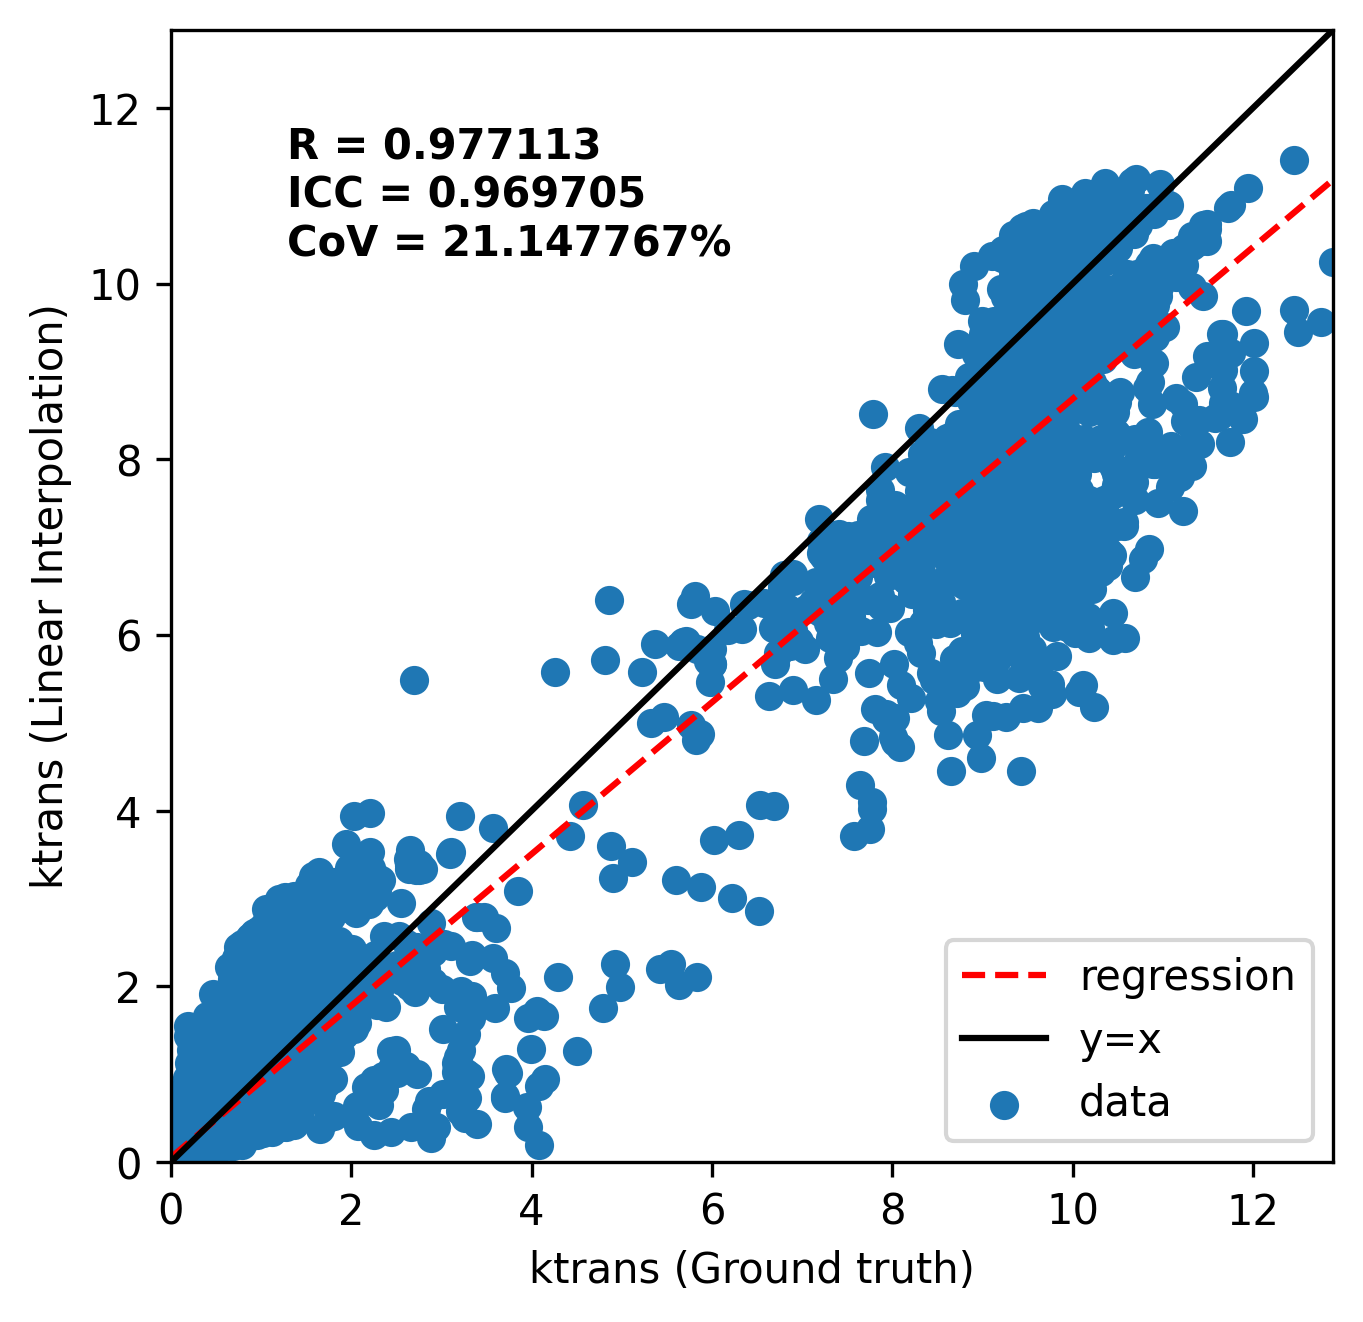

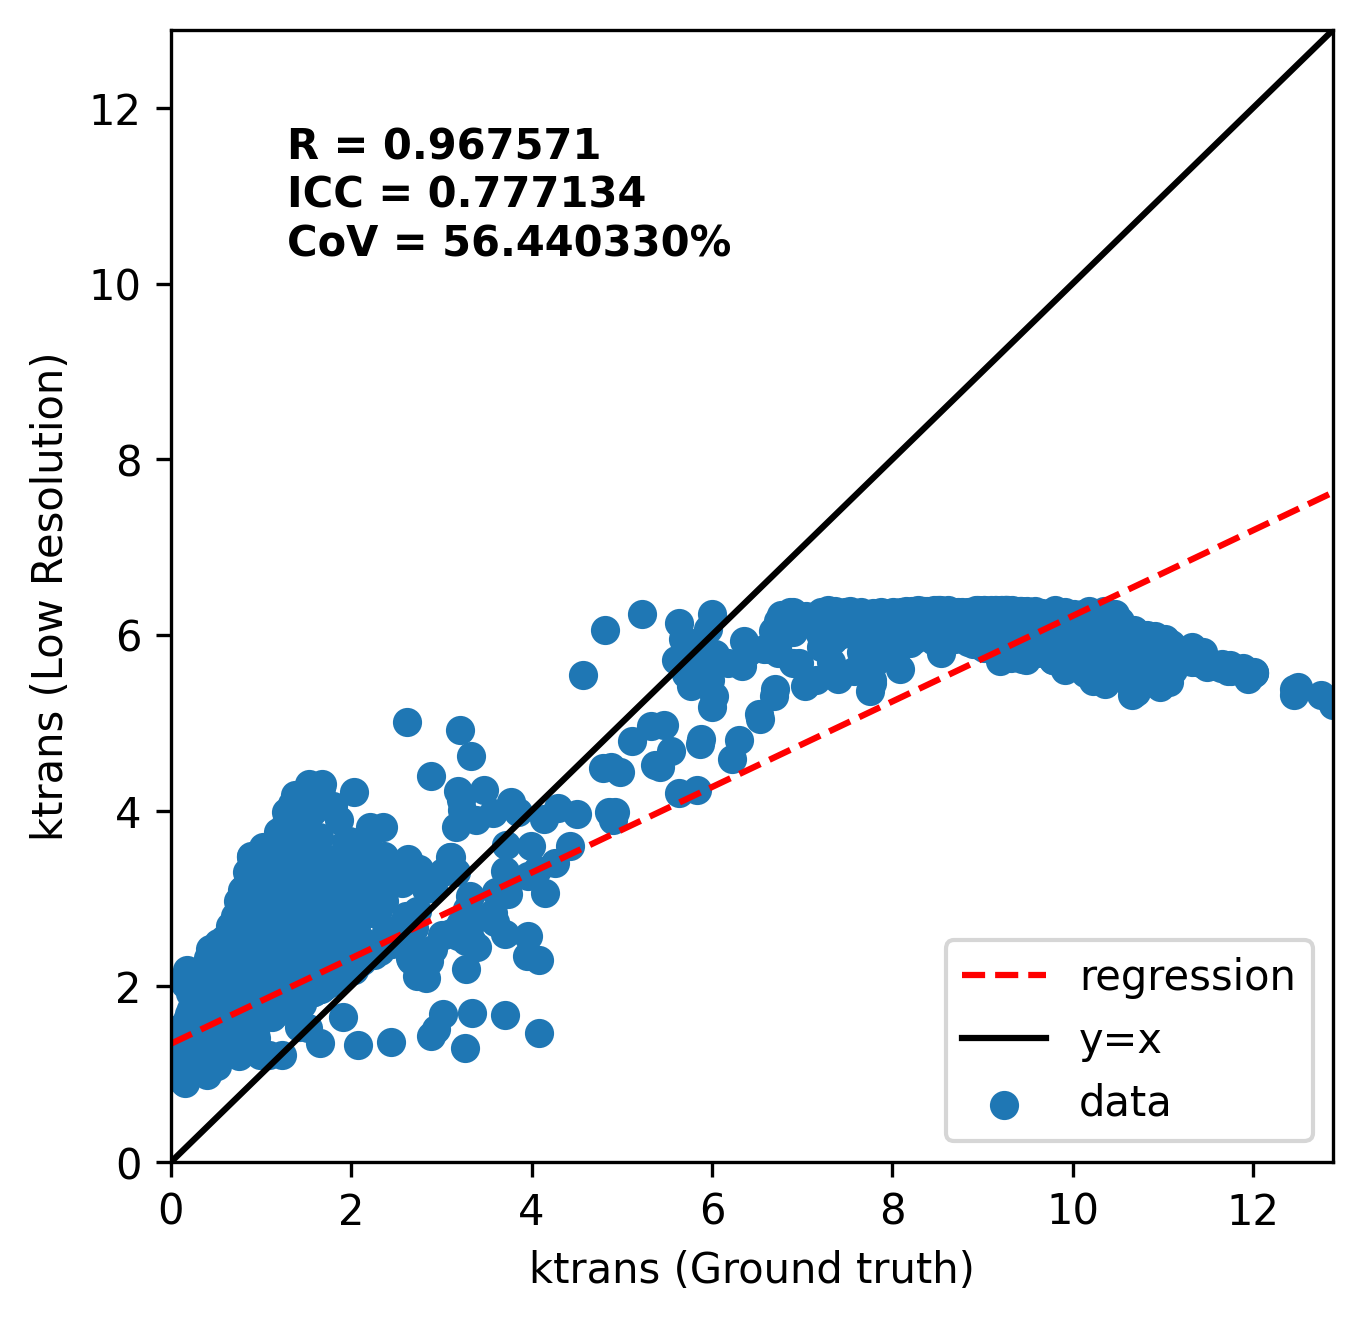

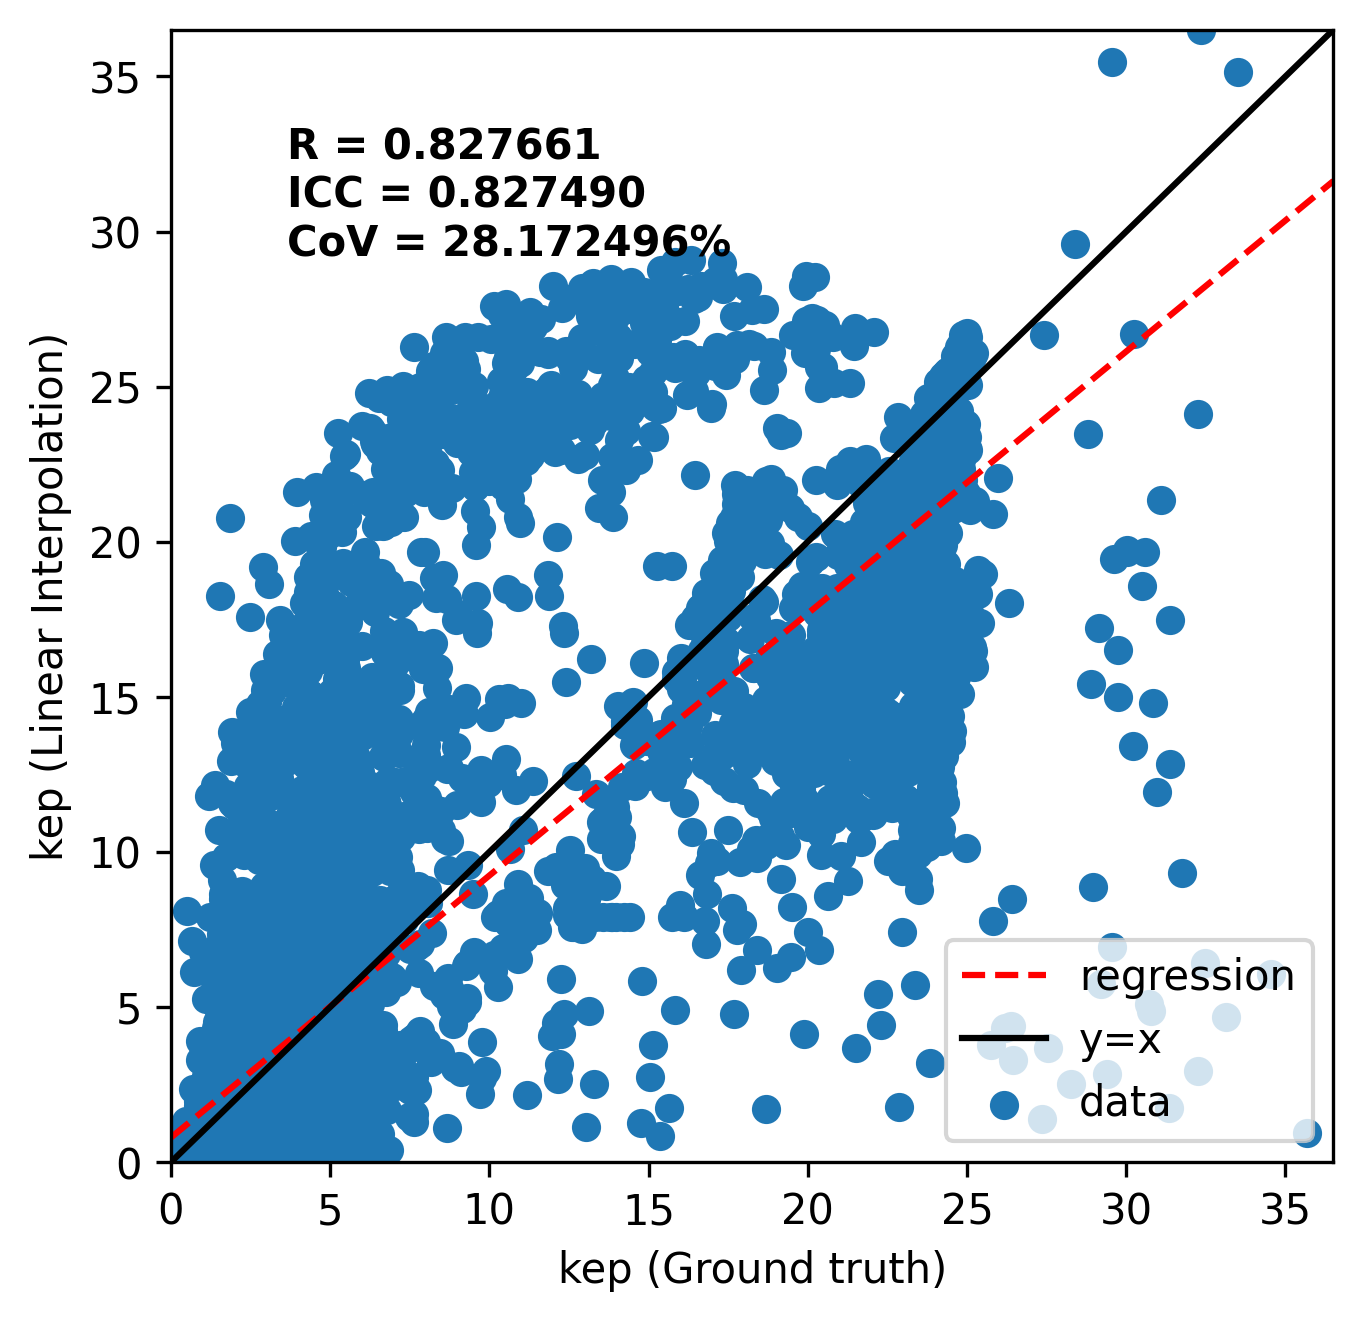

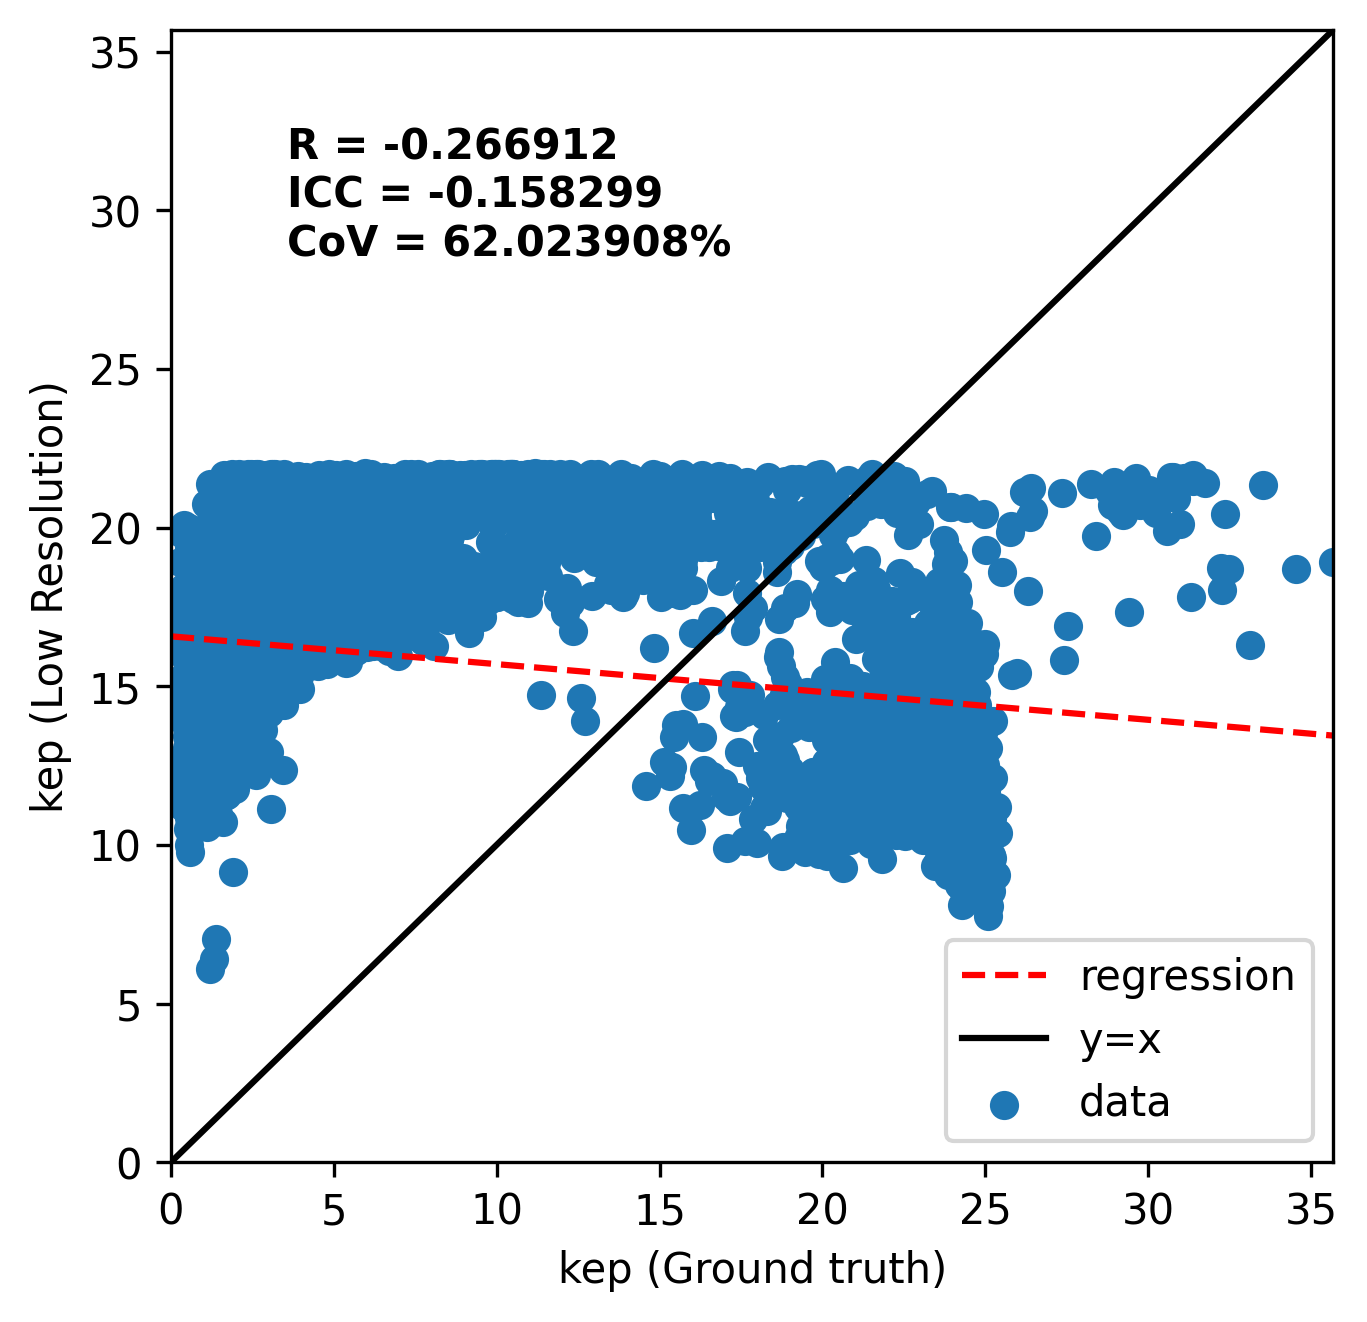

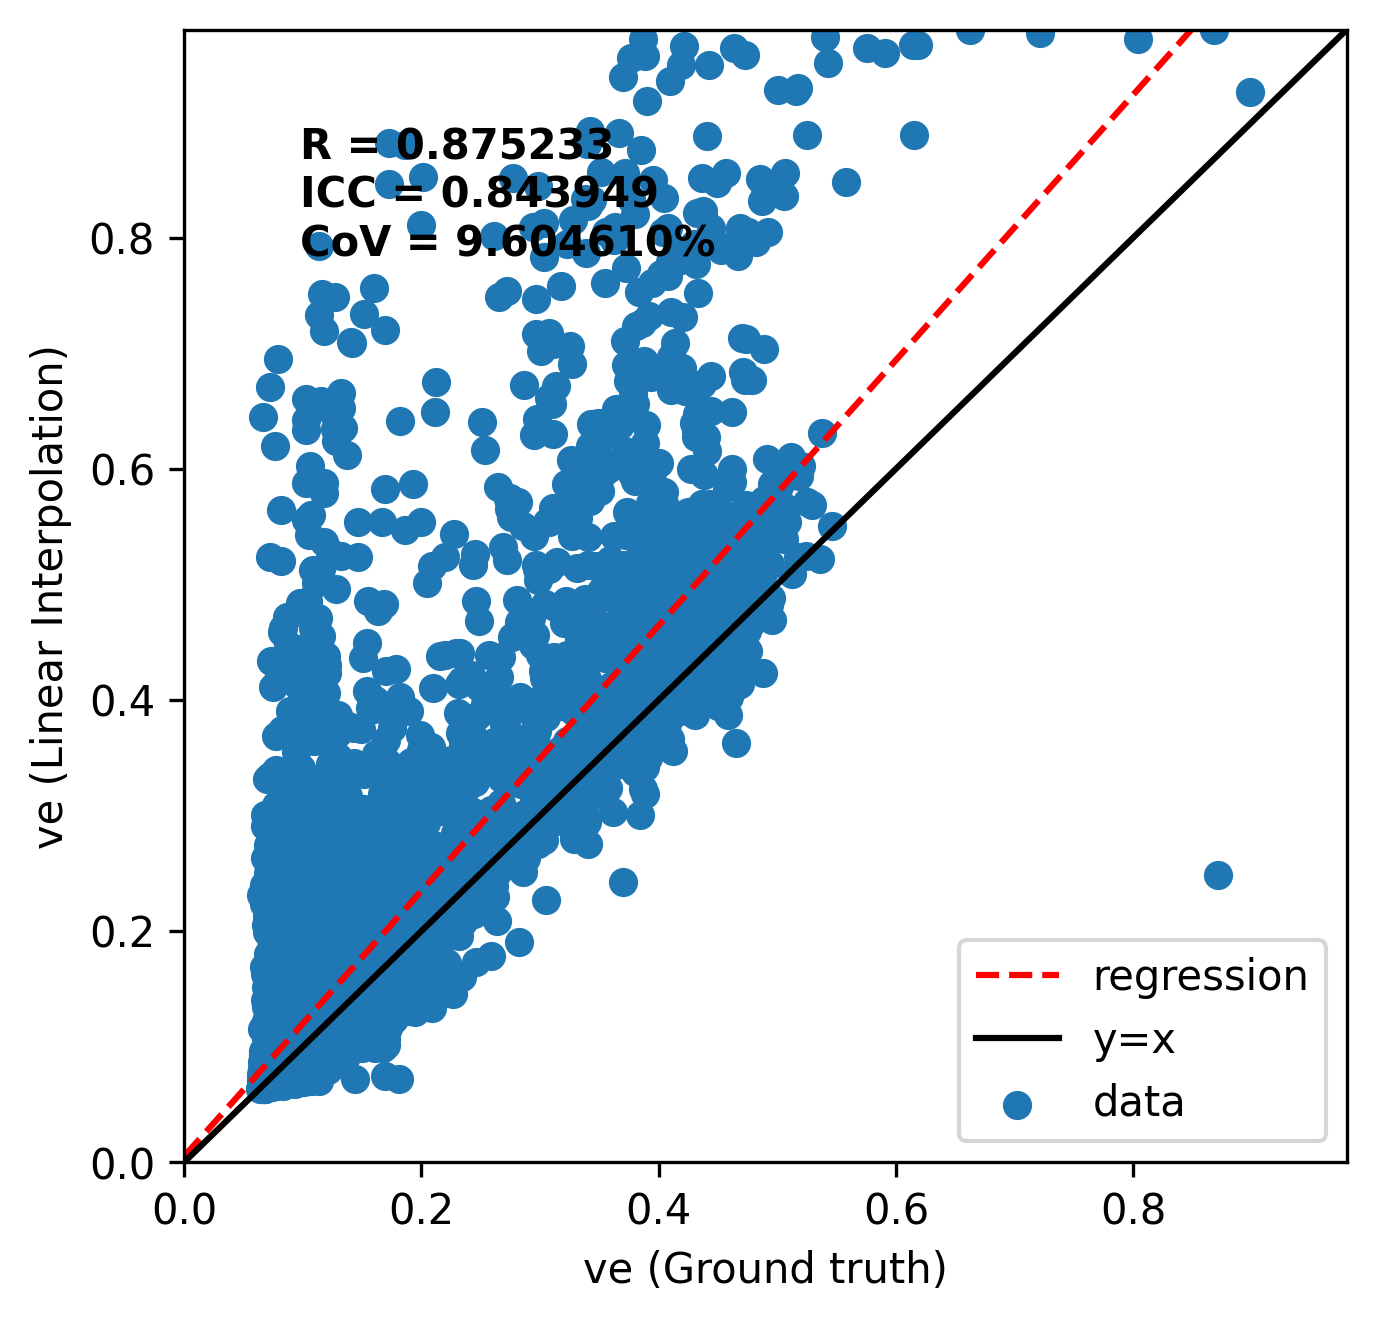

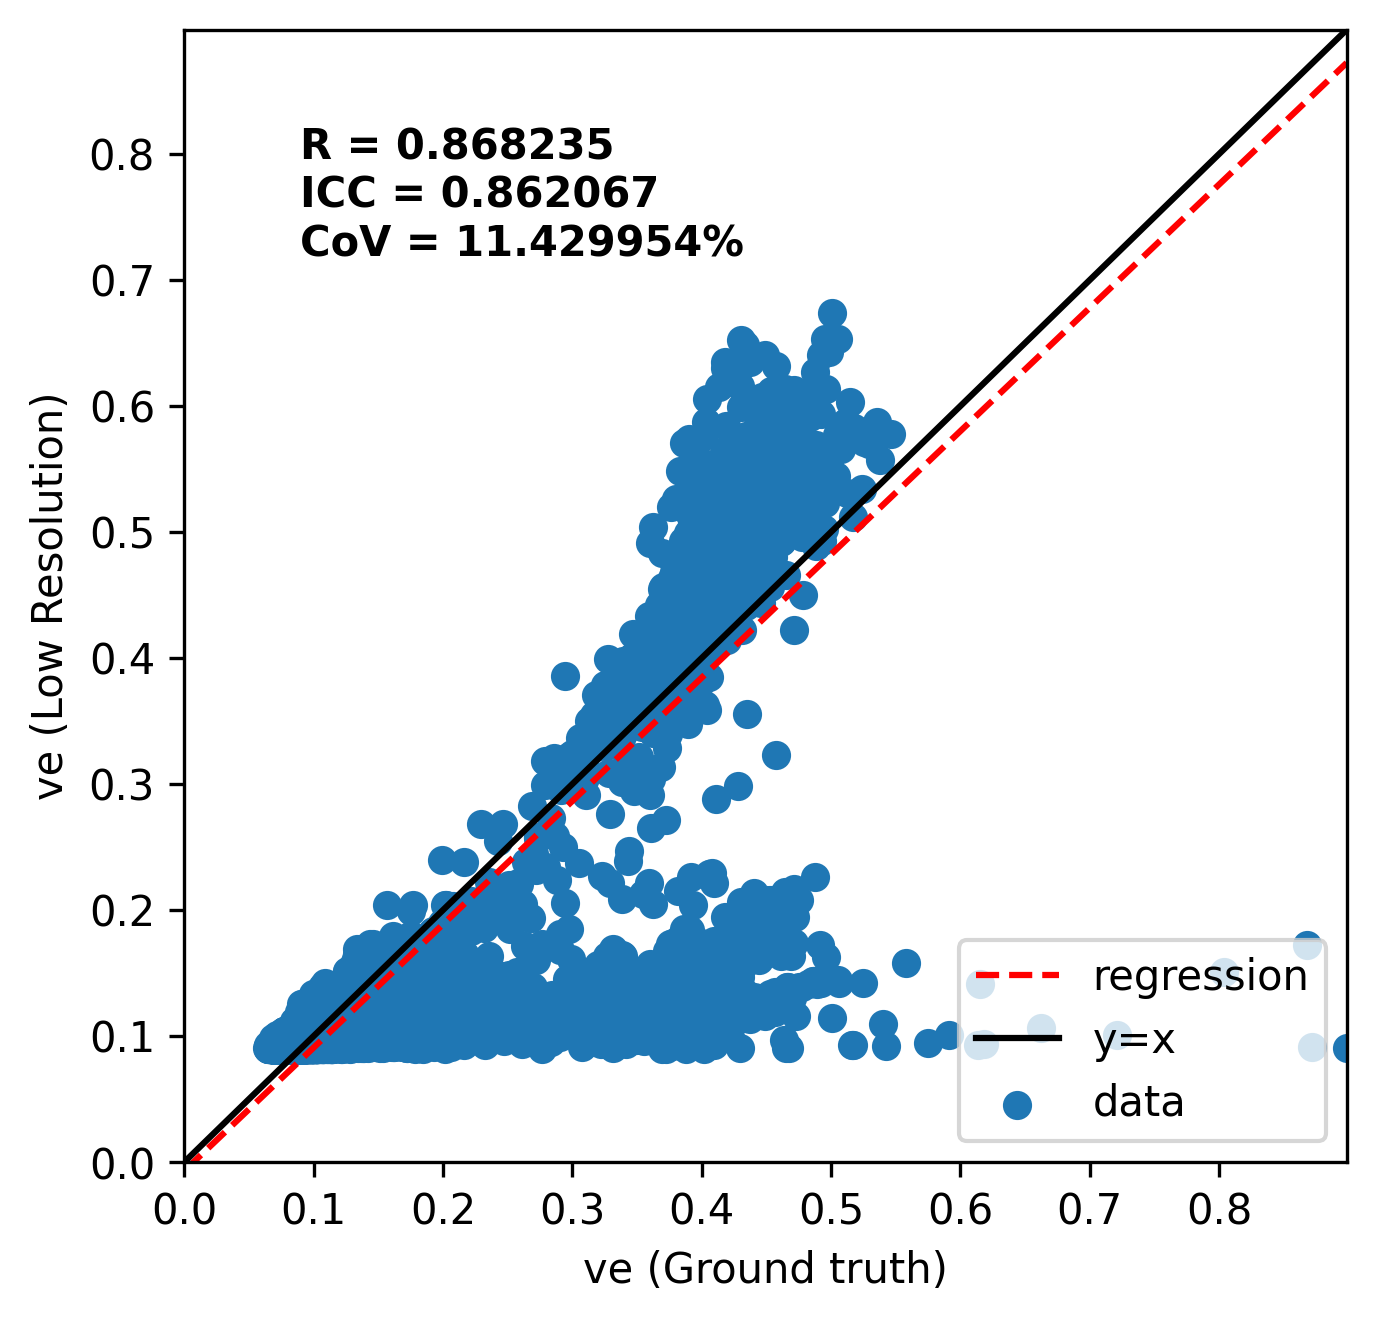

In [18]:

disp_name = {'Ground truth (VARPRO)':pk_gt_varpro,'Ground truth':pk_gt,'Linear Interpolation':pk_lp,'Low Resolution':pk_fl,'RoQ':pk_roq,'RoQ (VARPRO)':pk_roq_varpro}
pk_name = {'0':'ktrans','1':'kep','2':'ve'}
savepath = f"/home/chaowei/workspace/RoQ-DCE-DL/results/{prefix}"
for i in range(3):
    for j_name in ['Linear Interpolation','Low Resolution']:
        smart_mkdir(savepath)
        MyPlot(pk_gt[:,i],disp_name[j_name][:,i],[f"{pk_name[str(i)]} (Ground truth)",f"{pk_name[str(i)]} ({j_name})"],np.max((pk_gt[:,i],disp_name[j_name][:,i])),savepath,f"{pk_name[str(i)]}_{j_name}_gt",mode='do')

In [19]:
for j_name in ['Ground truth (VARPRO)','Ground truth','Linear Interpolation','RoQ','RoQ (VARPRO)']:
    np.save(f"{savepath}_{j_name}_largekep.npy",disp_name[j_name])

In [10]:
print(compute_nrmse(Y_fl_ts,Y_valid_ts),compute_nrmse(Y_fl_pl,Y_valid_pl))
print(compute_nrmse(Y_lp_ts,Y_valid_ts),compute_nrmse(Y_lp_pl,Y_valid_pl))
print(compute_nrmse(Y_roq_ts,Y_valid_ts),compute_nrmse(Y_roq_pl,Y_valid_pl))
print(compute_nrmse(Y_nopre_ts,Y_valid_ts),compute_nrmse(Y_nopre_pl,Y_valid_pl))

0.12189340656501318 0.36076394907782994
0.04602577769087202 0.18151093846460975
0.027277030679073992 0.08274959442081989
0.03189202894287105 0.08594473832257896


(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)


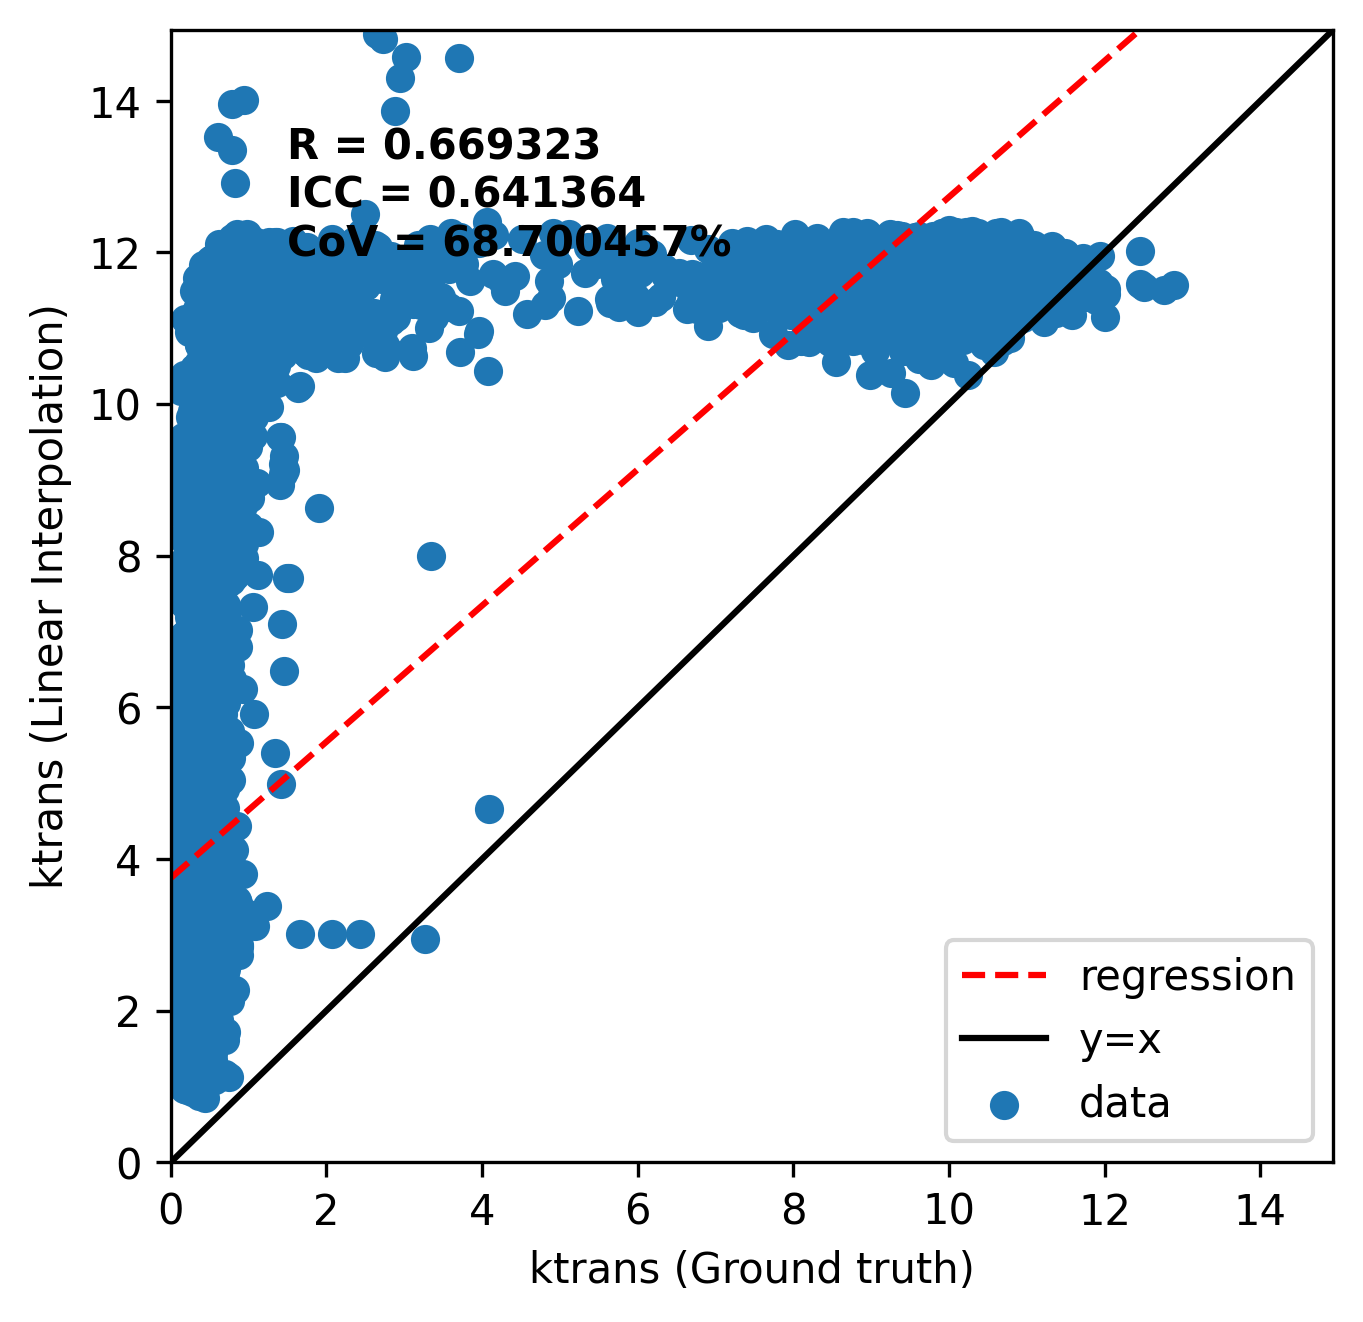

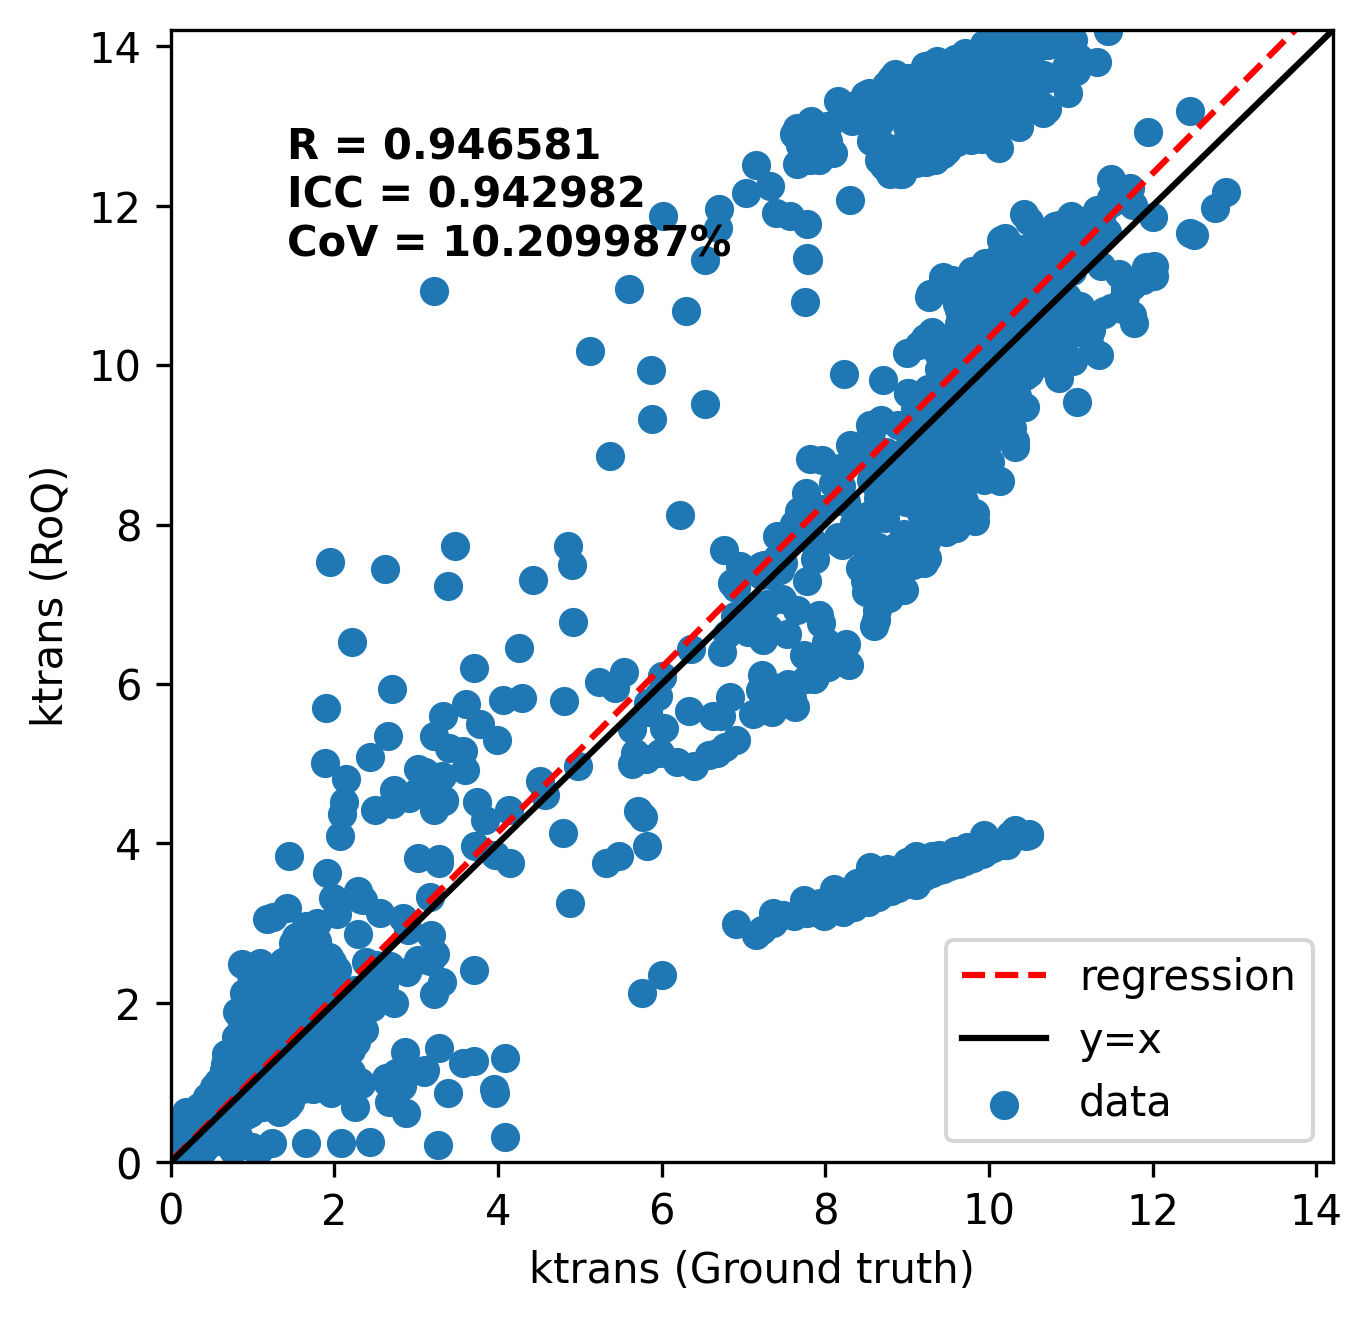

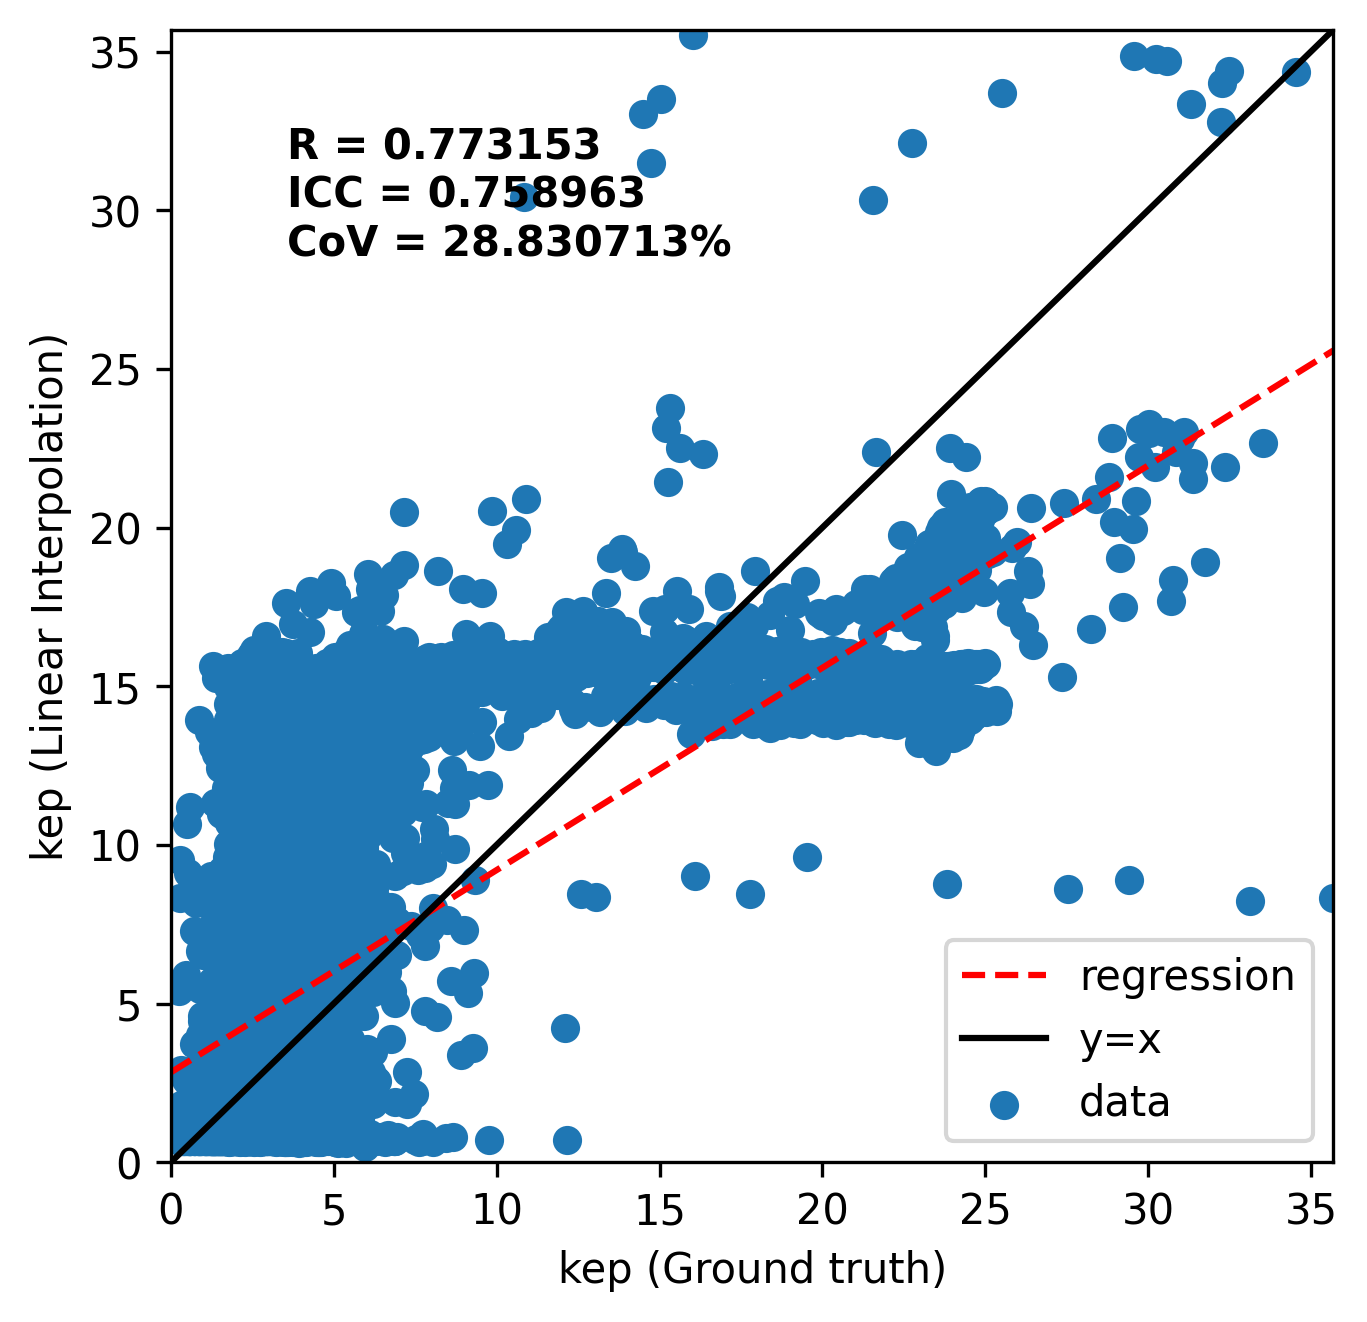

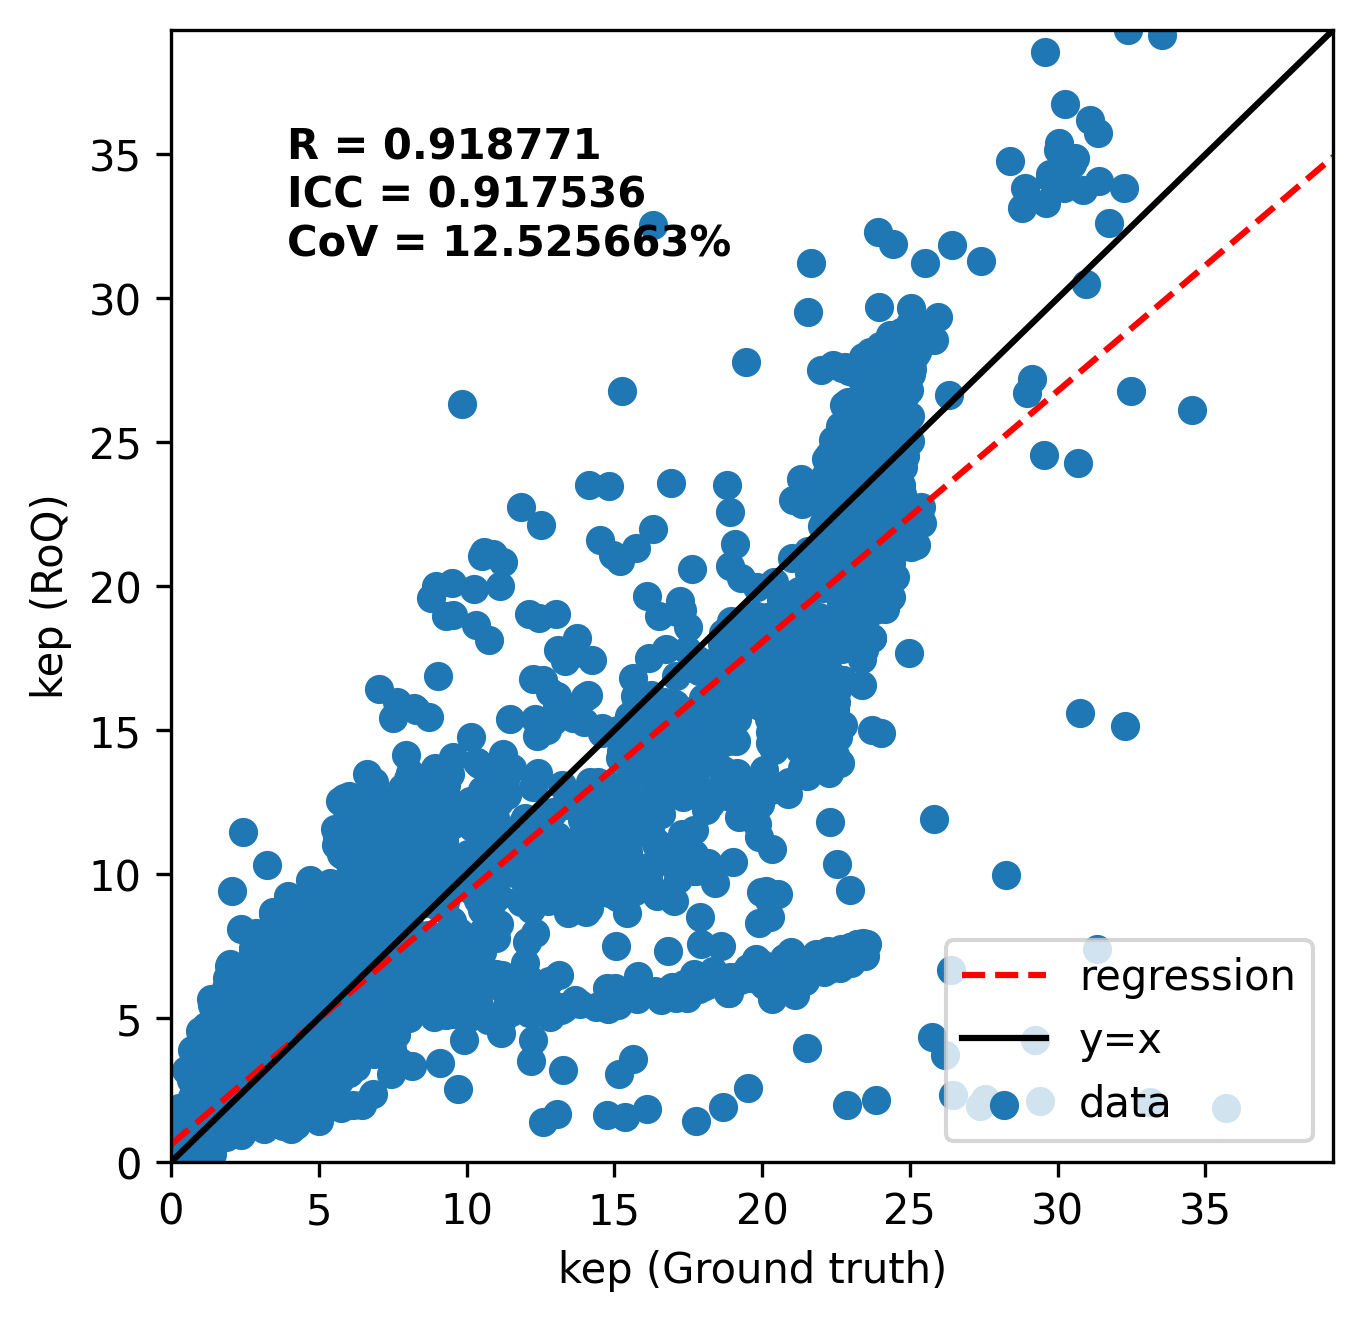

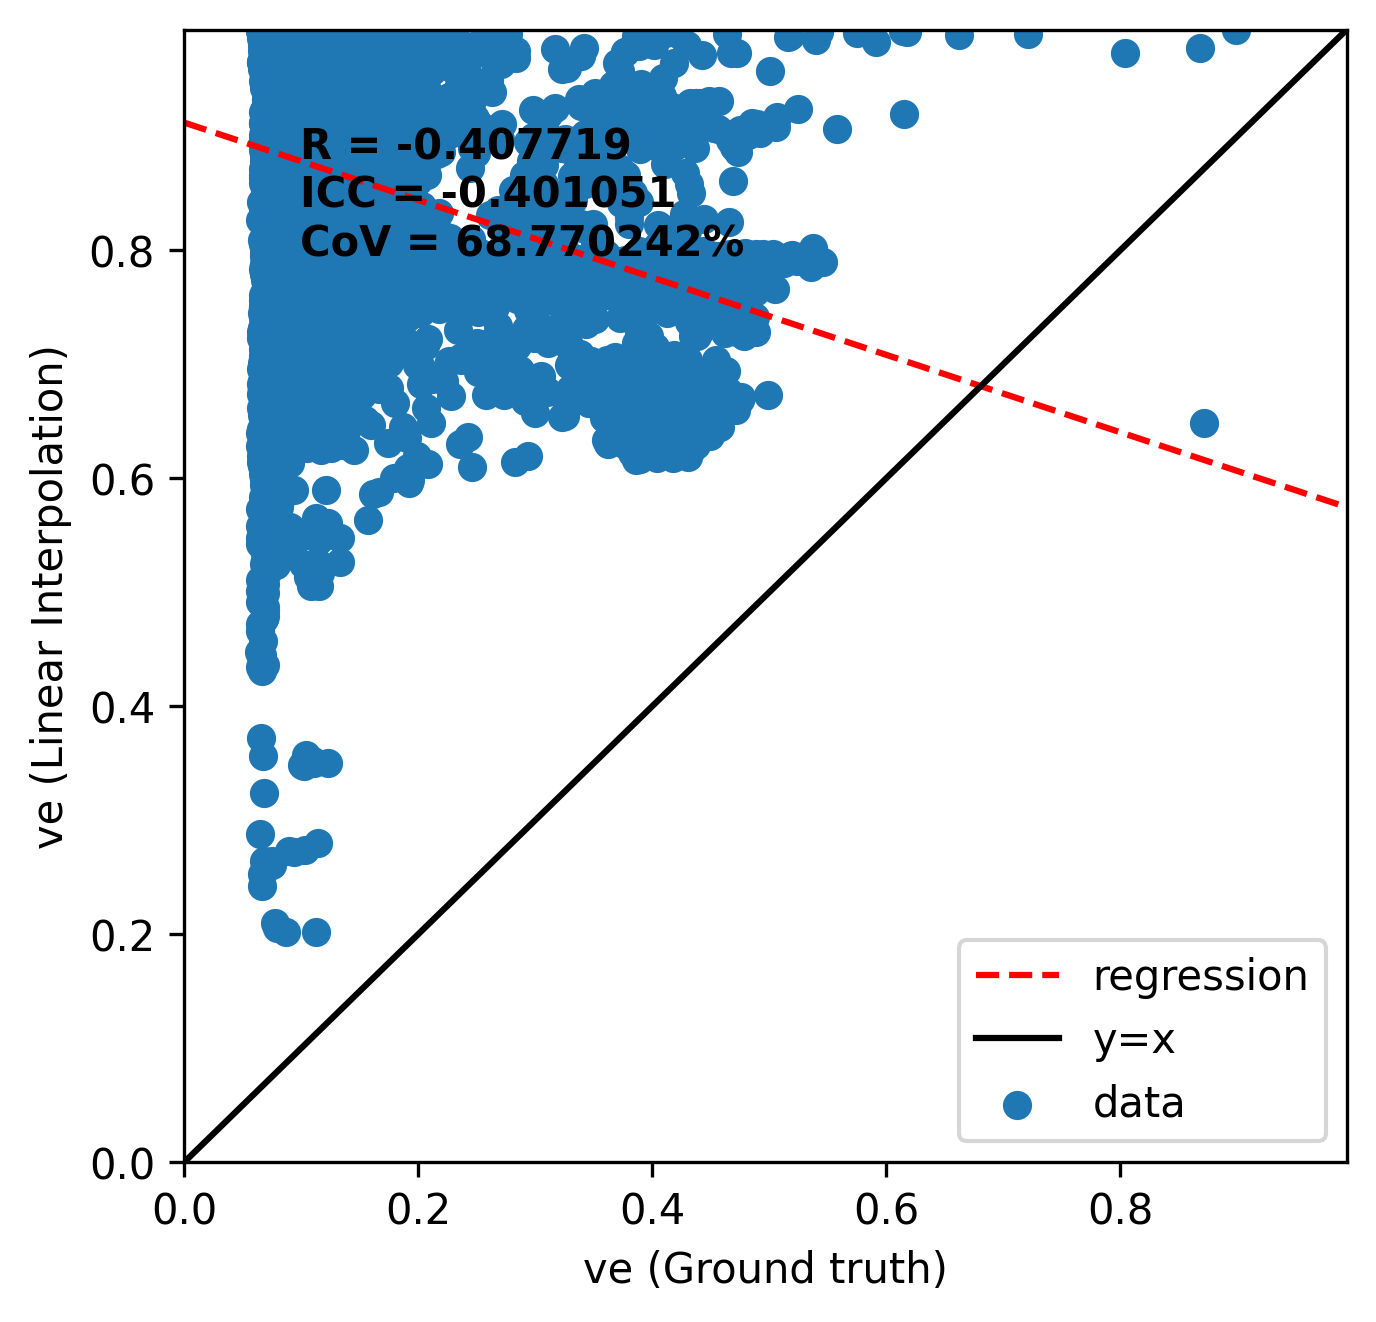

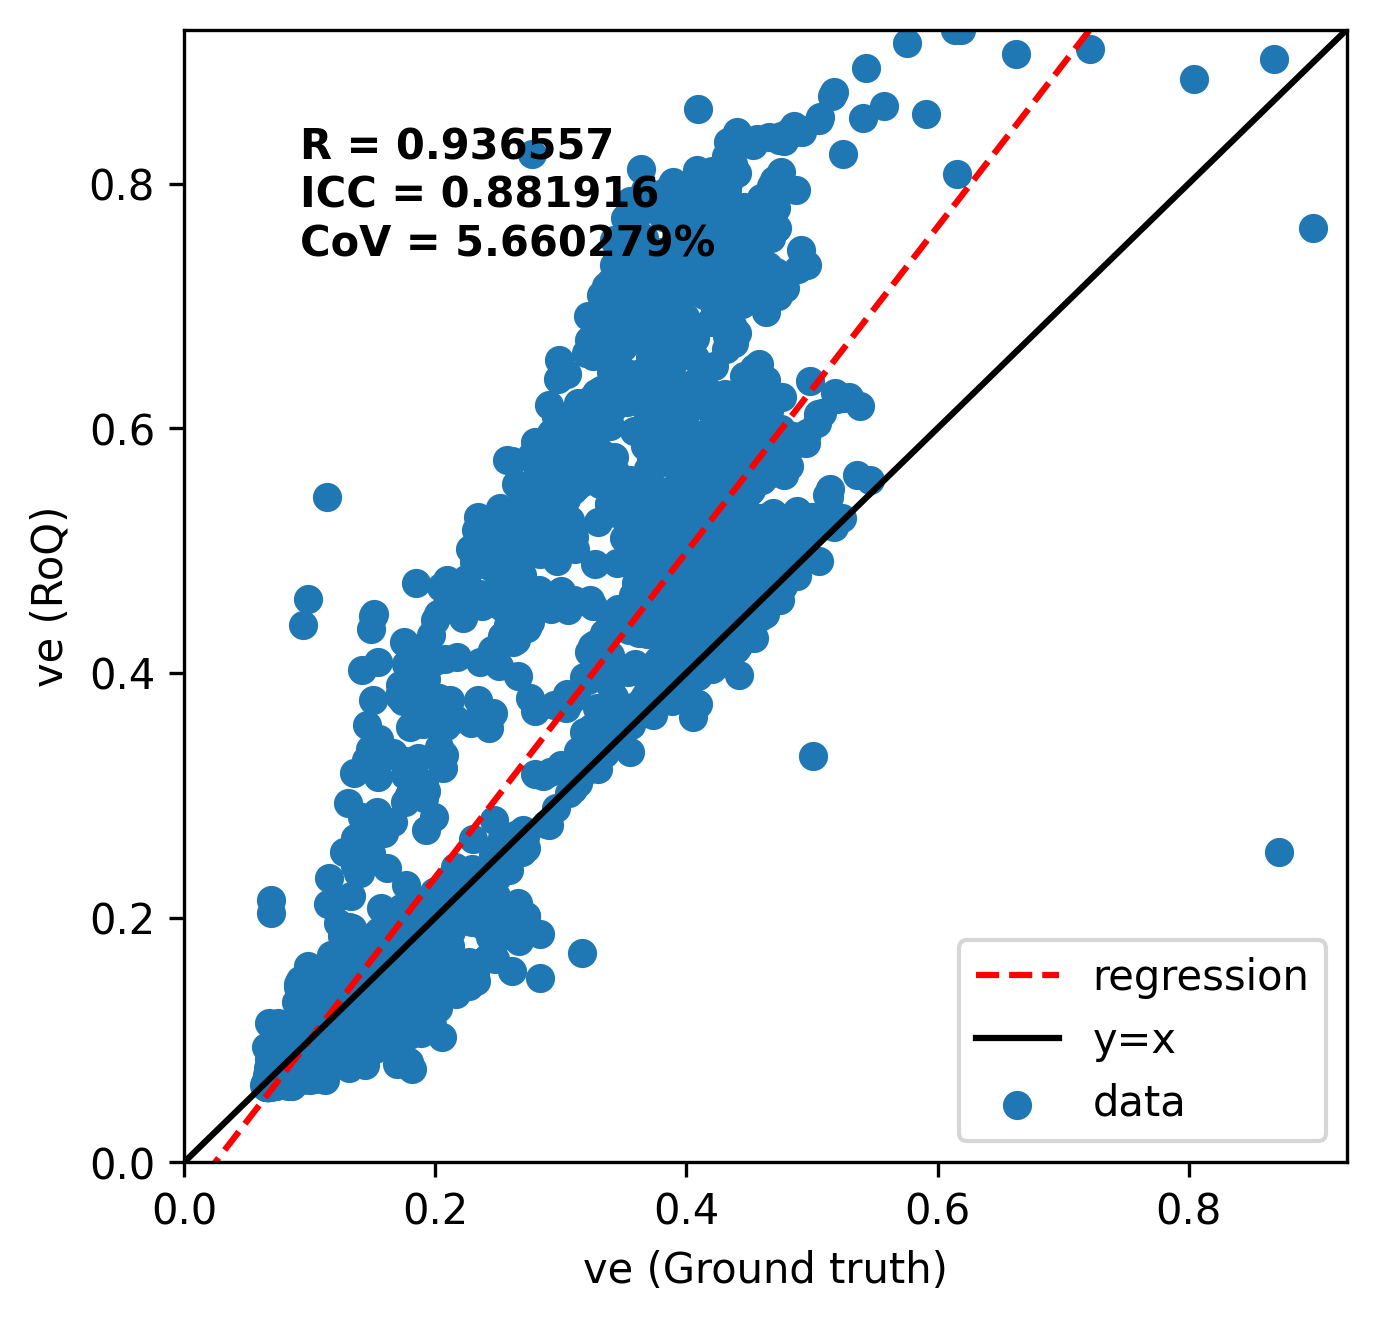

In [11]:

disp_name = {'Ground truth (VARPRO)':pk_gt_varpro,'Ground truth':pk_gt,'Linear Interpolation':pk_lp,'RoQ':pk_roq,'RoQ (VARPRO)':pk_roq_varpro}
pk_name = {'0':'ktrans','1':'kep','2':'ve'}
savepath = f"/home/chaowei/workspace/RoQ-DCE-DL/results/{prefix}"
for i in range(3):
    for j_name in ['Linear Interpolation','RoQ']:
        smart_mkdir(savepath)
        MyPlot(pk_gt[:,i],disp_name[j_name][:,i],[f"{pk_name[str(i)]} (Ground truth)",f"{pk_name[str(i)]} ({j_name})"],np.max((pk_gt[:,i],disp_name[j_name][:,i])),savepath,f"{pk_name[str(i)]}_{j_name}_gt",mode='do')